<h1 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  Import Libraries & Load Dataset
</h1>

In [340]:
# Library untuk manipulasi data dan visualisasi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from folium.plugins import MarkerCluster
from IPython.display import display
from tabulate import tabulate

# Library untuk waktu dan geolokasi
from datetime import datetime
from geopy.geocoders import Nominatim
from geopy.distance import geodesic

# Library untuk preprocessing dan evaluasi
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    make_scorer,
    silhouette_score,
    jaccard_score
)

# Library untuk klasifikasi, clustering, dan deteksi anomali
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import mahalanobis
from pyod.models.hbos import HBOS

# Library untuk reduksi dimensi
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Library tambahan
from scipy.stats import entropy
import warnings
warnings.filterwarnings('ignore')

# Library untuk deep learning (Keras)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2


In [341]:
# Setting tampilan visualisasi
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

In [342]:
# Tampilkan semua kolom
pd.set_option('display.max_columns', None)

In [343]:
# Load dataset
df = pd.read_csv('bank_transactions_data_2.csv')

<h1 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  EDA
</h1>

In [344]:
print("Shape dataset:", df.shape)
df.head()

Shape dataset: (2512, 16)


TransactionID AccountID  TransactionAmount      TransactionDate  \
0      TX000001   AC00128              14.09  2023-04-11 16:29:14   
1      TX000002   AC00455             376.24  2023-06-27 16:44:19   
2      TX000003   AC00019             126.29  2023-07-10 18:16:08   
3      TX000004   AC00070             184.50  2023-05-05 16:32:11   
4      TX000005   AC00411              13.45  2023-10-16 17:51:24   

  TransactionType   Location DeviceID      IP Address MerchantID Channel  \
0           Debit  San Diego  D000380  162.198.218.92       M015     ATM   
1           Debit    Houston  D000051     13.149.61.4       M052     ATM   
2           Debit       Mesa  D000235  215.97.143.157       M009  Online   
3           Debit    Raleigh  D000187  200.13.225.150       M002  Online   
4          Credit    Atlanta  D000308    65.164.3.100       M091  Online   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0           70             Doctor                   81              1   
1           68             Doctor                  141              1   
2           19            Student                   56              1   
3           26            Student                   25              1   
4           26            Student                  198              1   

   AccountBalance PreviousTransactionDate  
0         5112.21     2024-11-04 08:08:08  
1        13758.91     2024-11-04 08:09:35  
2         1122.35     2024-11-04 08:07:04  
3         8569.06     2024-11-04 08:09:06  
4         7429.40     2024-11-04 08:06:39

In [345]:
print("\nInfo dataset:")
df.info()


Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBa

In [346]:
# df.describe(include='all').T
print("Statistik deskriptif:")
display(df.describe().T)

Statistik deskriptif:


count         mean          std     min       25%  \
TransactionAmount    2512.0   297.593778   291.946243    0.26    81.885   
CustomerAge          2512.0    44.673965    17.792198   18.00    27.000   
TransactionDuration  2512.0   119.643312    69.963757   10.00    63.000   
LoginAttempts        2512.0     1.124602     0.602662    1.00     1.000   
AccountBalance       2512.0  5114.302966  3900.942499  101.25  1504.370   

                         50%        75%       max  
TransactionAmount     211.14   414.5275   1919.11  
CustomerAge            45.00    59.0000     80.00  
TransactionDuration   112.50   161.0000    300.00  
LoginAttempts           1.00     1.0000      5.00  
AccountBalance       4735.51  7678.8200  14977.99

In [347]:
# 2. Pengecekan Data
print("Missing values:", df.isna().sum().sum())
print("Duplicate values:", df.duplicated().sum())

Missing values: 0
Duplicate values: 0


In [348]:
# Analisis Frekuensi Akun
# Hitung frekuensi kemunculan tiap AccountID
frekuensi_akun = df['AccountID'].value_counts()
# Filter hanya yang duplikat (lebih dari 1 kali muncul)
akun_duplikat = frekuensi_akun[frekuensi_akun > 1].reset_index()
akun_duplikat.columns = ['AccountID', 'Jumlah_Transaksi']
print("Akun dengan transaksi ganda:")
display(akun_duplikat.head())

Akun dengan transaksi ganda:


AccountID  Jumlah_Transaksi
0   AC00362                12
1   AC00363                12
2   AC00202                12
3   AC00460                12
4   AC00257                11

In [349]:
# Unique values
print("Unique Values:")
df.nunique()

Unique Values:


TransactionID              2512
AccountID                   495
TransactionAmount          2455
TransactionDate            2512
TransactionType               2
Location                     43
DeviceID                    681
IP Address                  592
MerchantID                  100
Channel                       3
CustomerAge                  63
CustomerOccupation            4
TransactionDuration         288
LoginAttempts                 5
AccountBalance             2510
PreviousTransactionDate     360
dtype: int64

In [350]:
# Pemisahan Kolom Numerik dan Kategorik
numerical_columns = df.select_dtypes(include=['number']).columns.tolist()
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

print("\nKolom Numerik:", numerical_columns)
print("Kolom Kategorik:", categorical_columns)


Kolom Numerik: ['TransactionAmount', 'CustomerAge', 'TransactionDuration', 'LoginAttempts', 'AccountBalance']
Kolom Kategorik: ['TransactionID', 'AccountID', 'TransactionDate', 'TransactionType', 'Location', 'DeviceID', 'IP Address', 'MerchantID', 'Channel', 'CustomerOccupation', 'PreviousTransactionDate']


In [351]:
# Tampilkan nilai unik kolom kategorikal
unique_values_list = []

for col in categorical_columns:
    unique_values_list.append({
        "Column Name": col,
        "Unique Values": ", ".join(map(str, df[col].unique())),
        "Unique Count": df[col].nunique()
    })
unique_values_df = pd.DataFrame(unique_values_list)
unique_values_df

Column Name  \
0             TransactionID   
1                 AccountID   
2           TransactionDate   
3           TransactionType   
4                  Location   
5                  DeviceID   
6                IP Address   
7                MerchantID   
8                   Channel   
9        CustomerOccupation   
10  PreviousTransactionDate   

                                        Unique Values  Unique Count  
0   TX000001, TX000002, TX000003, TX000004, TX0000...          2512  
1   AC00128, AC00455, AC00019, AC00070, AC00411, A...           495  
2   2023-04-11 16:29:14, 2023-06-27 16:44:19, 2023...          2512  
3                                       Debit, Credit             2  
4   San Diego, Houston, Mesa, Raleigh, Atlanta, Ok...            43  
5   D000380, D000051, D000235, D000187, D000308, D...           681  
6   162.198.218.92, 13.149.61.4, 215.97.143.157, 2...           592  
7   M015, M052, M009, M002, M091, M054, M019, M020...           100  
8                                 ATM, Online, Branch             3  
9                  Doctor, Student, Retired, Engineer             4  
10  2024-11-04 08:08:08, 2024-11-04 08:09:35, 2024...           360

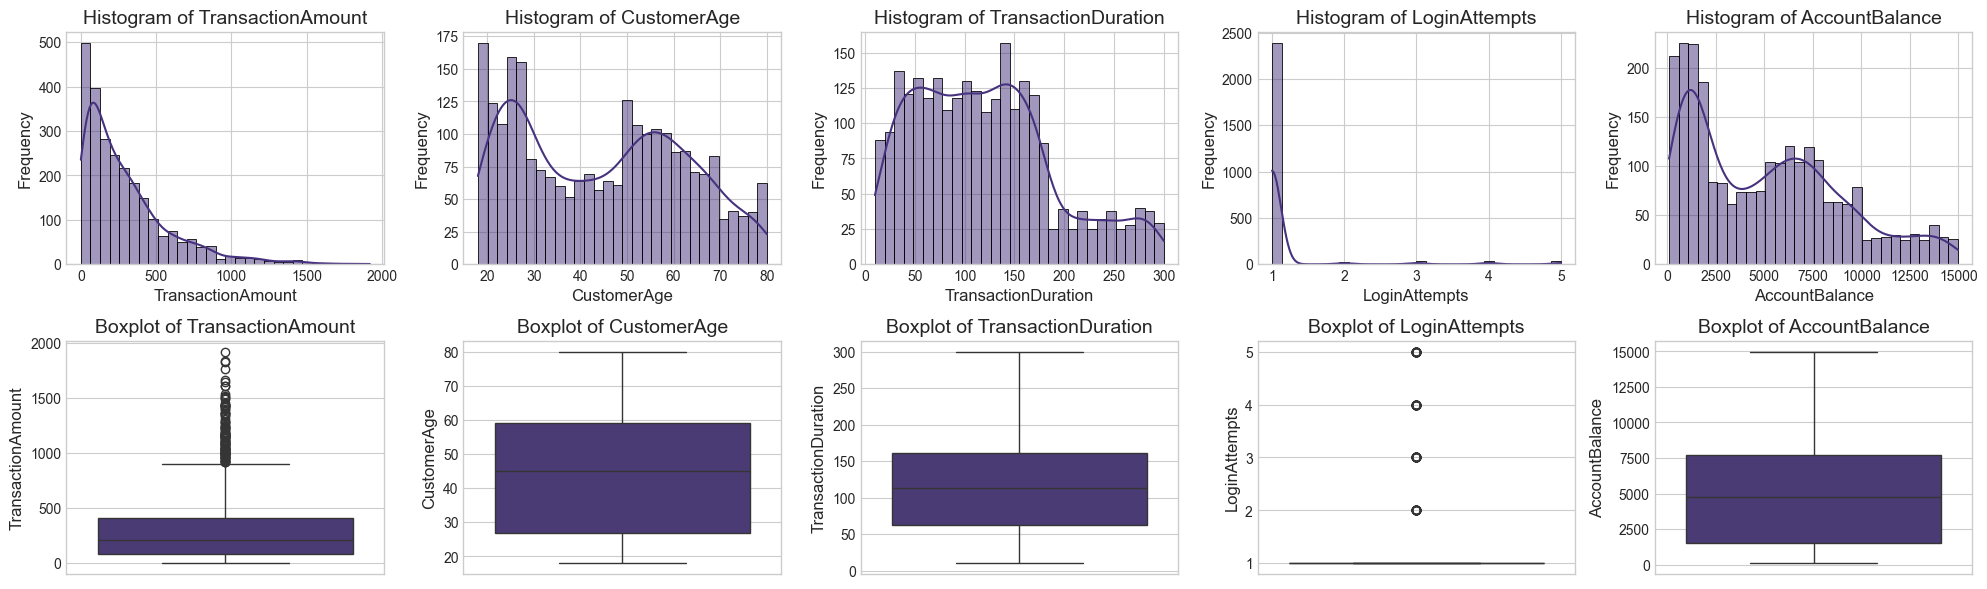

count         mean          std     min       25%  \
TransactionAmount    2512.0   297.593778   291.946243    0.26    81.885   
CustomerAge          2512.0    44.673965    17.792198   18.00    27.000   
TransactionDuration  2512.0   119.643312    69.963757   10.00    63.000   
LoginAttempts        2512.0     1.124602     0.602662    1.00     1.000   
AccountBalance       2512.0  5114.302966  3900.942499  101.25  1504.370   

                         50%        75%       max  
TransactionAmount     211.14   414.5275   1919.11  
CustomerAge            45.00    59.0000     80.00  
TransactionDuration   112.50   161.0000    300.00  
LoginAttempts           1.00     1.0000      5.00  
AccountBalance       4735.51  7678.8200  14977.99

In [352]:
# Tampilkan histogram dan boxplot
def plot_univariate_analysis(df, numerical_columns):
    num_cols = len(numerical_columns)
    plt.figure(figsize=(num_cols * 4, 6))

    # Plot histogram baris pertama
    for i, column in enumerate(numerical_columns):
        plt.subplot(2, num_cols, i + 1)
        sns.histplot(df[column], bins=30, kde=True)
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')

    # Plot boxplot baris kedua
    for i, column in enumerate(numerical_columns):
        plt.subplot(2, num_cols, num_cols + i + 1)
        sns.boxplot(y=df[column])
        plt.title(f'Boxplot of {column}')
        plt.ylabel(column)

    plt.tight_layout()
    plt.show()

plot_univariate_analysis(df, numerical_columns)

# Statistic Summary
summary_table = df[numerical_columns].describe().T
summary_table


Text(0, 0.5, 'Location')

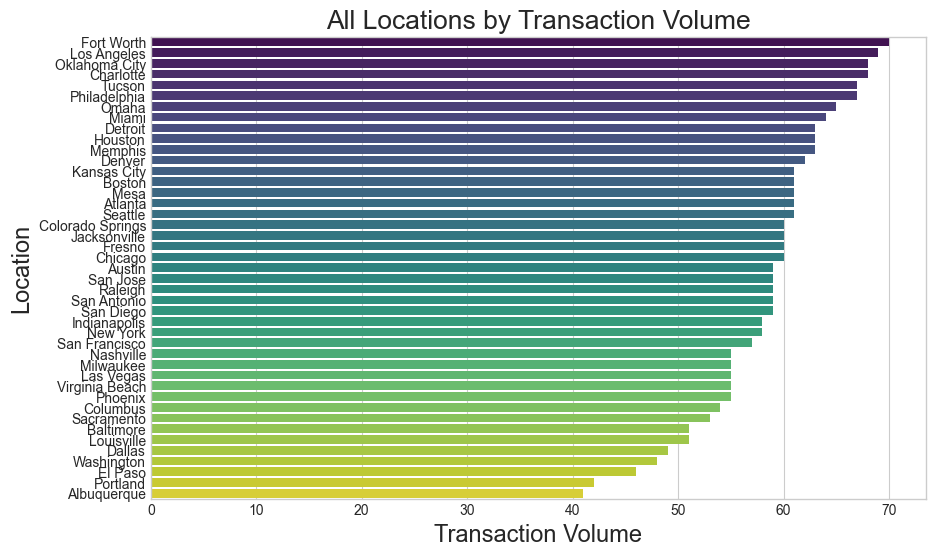

In [353]:
all_locations = df['Location'].value_counts().head(43)

plt.figure(figsize=(10,6))
sns.barplot(y=all_locations.index, x=all_locations.values, palette='viridis')
plt.title('All Locations by Transaction Volume', fontsize=19)
plt.xlabel('Transaction Volume', fontsize=17)
plt.ylabel('Location', fontsize=17)

In [354]:
unique_locations = df['Location'].unique()
location_coords = {}

geolocator = Nominatim(user_agent="location_mapper")

for location in unique_locations:
    try:
        loc = geolocator.geocode(location)
        if loc:
            location_coords[location] = (loc.latitude, loc.longitude)
        else:
            print(f"Coordinates not found for {location}")
    except Exception as e:
        print(f"Error fetching coordinates for {location} : {e}")
        
df['Coordinates'] = df['Location'].map(location_coords)

In [355]:
initial_coords = list(location_coords.values())[0] if location_coords else [0, 0]
mymap = folium.Map(location=initial_coords, zoom_start=5)
marker_cluster = MarkerCluster().add_to(mymap)

for _, row in df.dropna(subset=['Coordinates']).iterrows():  # Hanya baris dengan koordinat
    folium.Marker(
        location=row['Coordinates'],
        popup=f"TransactionID: {row['TransactionID']}<br>Amount: ${row['TransactionAmount']}",
        tooltip=row['Location']
    ).add_to(marker_cluster)

mymap


In [356]:
df_grouped = df.groupby('Location').agg({
    'Coordinates': 'first',
    'TransactionID': 'count',
    'TransactionAmount': 'sum'
}).reset_index()

df_grouped['Latitude'] = df_grouped['Coordinates'].apply(lambda x: x[0] if isinstance(x, tuple) else None)
df_grouped['Longitude'] = df_grouped['Coordinates'].apply(lambda x: x[1] if isinstance(x, tuple) else None)

fig = px.scatter_mapbox(df_grouped,
                        lat="Latitude",
                        lon="Longitude",
                        hover_name="Location",
                        hover_data={"TransactionID": True,  # ini jumlah transaksi
                                    "TransactionAmount": True},  # ini total nominal
                        zoom=3,
                        height=600)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


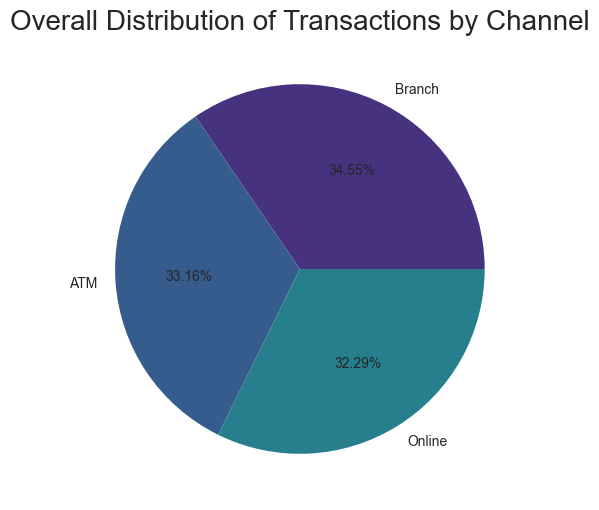

In [357]:
plt.figure(figsize=(10, 6))

branch_counts = df[df['Channel']=='Branch']['Channel'].count()
atm_counts = df[df['Channel']=='ATM']['Channel'].count()
online_counts = df[df['Channel']=='Online']['Channel'].count()
index_values = [branch_counts, atm_counts, online_counts]
index_labels = ['Branch', 'ATM', 'Online']

plt.pie(index_values, labels = index_labels, autopct='%2.2f%%')

plt.title('Overall Distribution of Transactions by Channel', fontsize=20)

plt.show()

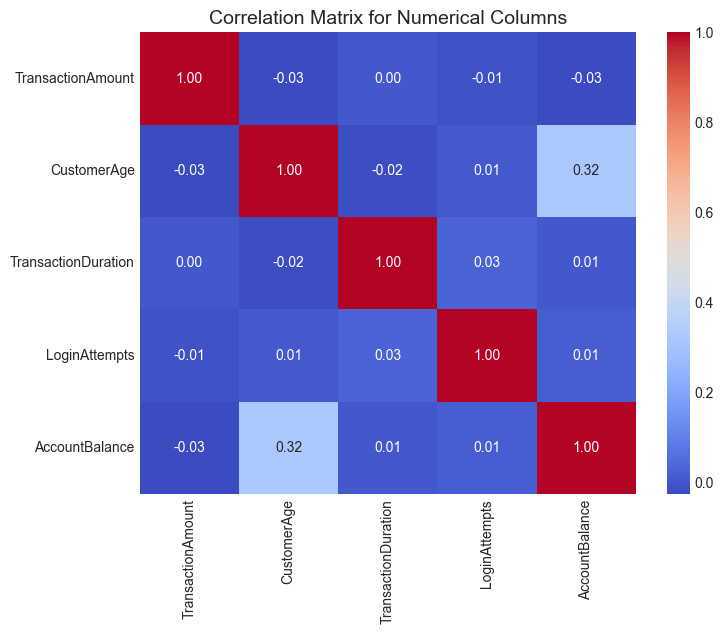

In [358]:
# Display correlation matrix for numerical columns
correlation_matrix = df[numerical_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Numerical Columns')
plt.show()

<h1 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  Feature Engineering
</h1>

In [359]:
# Ekstraksi Fitur Temporal, mengubah ke format datetime
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])
df["PreviousTransactionDate"] = pd.to_datetime(df["PreviousTransactionDate"])

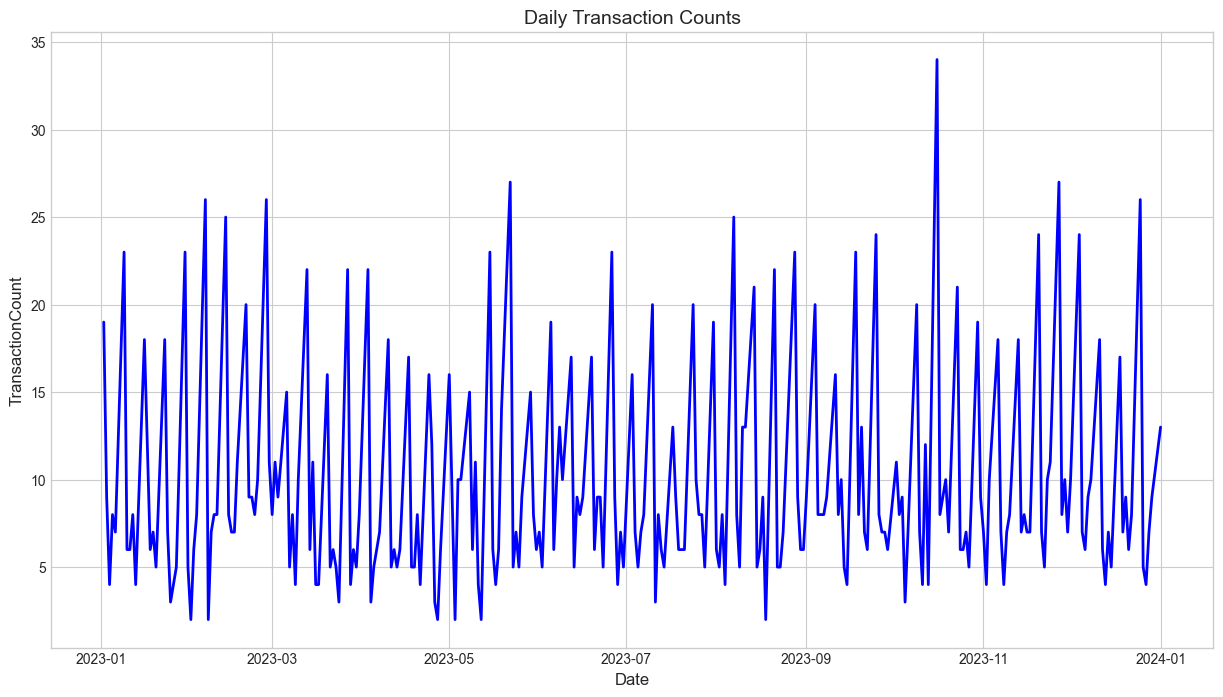

In [360]:
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df['TransactionDay'] = df['TransactionDate'].dt.date
daily_counts = df.groupby('TransactionDay').size() #count gives count of each column in the dataframe
plt.figure(figsize=(15,8))
daily_counts.plot(title='Daily Transaction Counts', color='blue', linewidth=2)
plt.xlabel('Date')
plt.ylabel('TransactionCount')
plt.show()

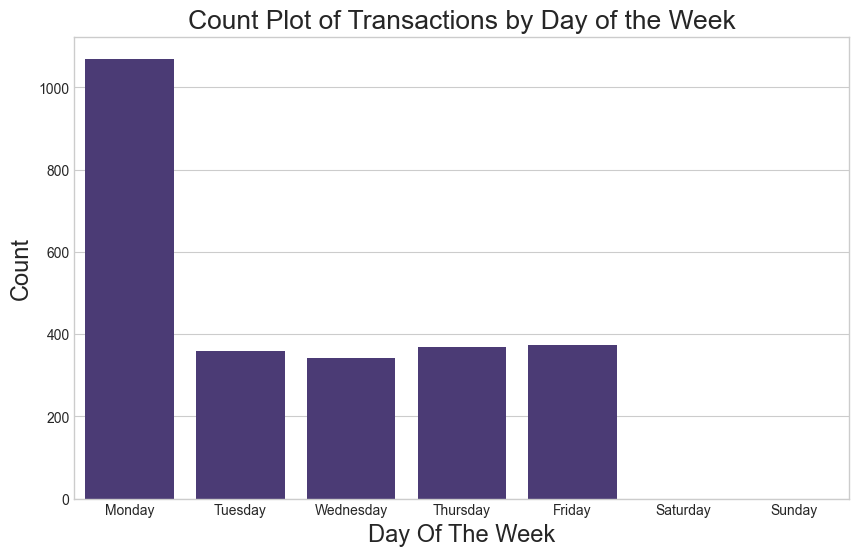

In [361]:
df_days = pd.DataFrame({'DayOfWeek_day': df['TransactionDate'].dt.day_name()})
plt.figure(figsize=(10,6))
sns.countplot(data=df_days, x='DayOfWeek_day', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Count Plot of Transactions by Day of the Week', fontsize=19)
plt.xlabel('Day Of The Week', fontsize=17)
plt.ylabel('Count', fontsize=17)
plt.show()

In [362]:
# Ekstrak jam, hari, weekend, bulan dari tanggal transaksi
df["Hour"] = df["TransactionDate"].dt.hour
df["DayOfWeek"] = df["TransactionDate"].dt.dayofweek
df["Weekend"] = df["DayOfWeek"].apply(lambda x: 1 if x >= 5 else 0)
df["Month"] = df["TransactionDate"].dt.month

# Hitung selisih waktu dengan transaksi sebelumnya (dalam jam)
df["TimeSinceLastTx"] = (df["TransactionDate"] - df["PreviousTransactionDate"]).dt.total_seconds() / 3600

In [363]:
if "AccountID" in df.columns:
    # Kelompokkan berdasarkan AccountID
    account_groups = df.groupby("AccountID")
    
# Statistik frekuensi transaksi
# Jumlah transaksi per akun
df["AccountTxCount"] = account_groups["TransactionID"].transform('count')
    
# Rata-rata jumlah transaksi per akun
df["AccountAvgAmount"] = account_groups["TransactionAmount"].transform('mean')

# Standar deviasi nominal Simpangan baku dari jumlah transaksi per akun
df["AccountStdAmount"] = account_groups["TransactionAmount"].transform('std').fillna(0)  

# Rasio nominal transaksi terhadap rata-rata akun
df["TxToAccountAvgRatio"] = df["TransactionAmount"] / df["AccountAvgAmount"]
# Handle nilai tak terhingga dan NaN
df["TxToAccountAvgRatio"] = df["TxToAccountAvgRatio"].replace([np.inf, -np.inf], 1).fillna(1)

In [364]:
# Rasio transaksi terhadap rata-rata tipe transaksi
avg_tx_amount_by_type = df.groupby('TransactionType')['TransactionAmount'].transform('mean')
df['Amount_to_AvgByType_Ratio'] = df['TransactionAmount'] / avg_tx_amount_by_type

# Hitung jumlah transaksi per perangkat (DeviceID)
df['DeviceTxCount'] = df.groupby('DeviceID')['DeviceID'].transform('count')

In [365]:
# Fitur berbasis waktu
if 'TimeSinceLastTx' in df.columns:
    # Statistik waktu antar transaksi
    df["AccountAvgTimeBetweenTx"] = account_groups["TimeSinceLastTx"].transform('mean')
    # Rasio waktu transaksi terakhir terhadap rata-rata
    df["TimeSinceLastTxRatio"] = df["TimeSinceLastTx"] / df["AccountAvgTimeBetweenTx"]
    df["TimeSinceLastTxRatio"] = df["TimeSinceLastTxRatio"].replace([np.inf, -np.inf], 1).fillna(1)
    

In [366]:
# Urutkan transaksi berdasarkan akun dan tanggal
df = df.sort_values(['AccountID', 'TransactionDate'])

# Isi nilai NaN (transaksi pertama)
df['TimeSinceLastTx'].fillna(df['TimeSinceLastTx'].median(), inplace=True)
        
# Hitung kecepatan transaksi (jumlah transaksi per hari)
account_velocity = account_groups.apply(
    lambda x: len(x) / ((x['TransactionDate'].max() - x['TransactionDate'].min()).total_seconds() / 86400)
    if len(x) > 1 else 0
).reset_index(name='AccountTxVelocity')
df = pd.merge(df, account_velocity, on='AccountID', how='left')
        
# Tangani akun dengan hanya satu transaksi
df['AccountTxVelocity'].fillna(0, inplace=True)

In [367]:
# Urutkan transaksi berdasarkan akun dan tanggal
df = df.sort_values(['AccountID', 'TransactionDate'])

# Hitung lokasi dan waktu sebelumnya
df['PrevLocation'] = df.groupby('AccountID')['Location'].shift(1)
df['PrevLocationCoordinates'] = df['PrevLocation'].map(location_coords)
df['PreviousTransactionDate'] = df.groupby('AccountID')['TransactionDate'].shift(1)

# Hitung waktu antar transaksi dalam jam
df['TimeSinceLastTx'] = (df['TransactionDate'] - df['PreviousTransactionDate']).dt.total_seconds() / 3600

# Isi NaN TimeSinceLastTx (misalnya transaksi pertama dalam akun)
df['TimeSinceLastTx'].fillna(df['TimeSinceLastTx'].median(), inplace=True)

# Hitung jarak antar lokasi (dalam kilometer)
def calculate_distance(row):
    if pd.isna(row['PrevLocationCoordinates']) or pd.isna(row['Coordinates']):
        return 0
    try:
        return geodesic(row['Coordinates'], row['PrevLocationCoordinates']).km
    except:
        return 0

df['DistanceFromLastTx'] = df.apply(calculate_distance, axis=1)

# Hitung kecepatan (km/jam)
df['Velocity'] = df['DistanceFromLastTx'] / (df['TimeSinceLastTx'] + 0.001)

# Tandai kecepatan tidak wajar (> 800 km/jam)
df['UnrealisticVelocity'] = (df['Velocity'] > 800).astype(int)

# Statistik ringkas
print(df['Velocity'].describe())
print("Jumlah transaksi dengan kecepatan tidak wajar (>800 km/jam):", df['UnrealisticVelocity'].sum())

count     2512.000000
mean        69.940080
std       1754.764165
min          0.000000
25%          0.175647
50%          1.095573
75%          3.218231
max      84717.163356
Name: Velocity, dtype: float64
Jumlah transaksi dengan kecepatan tidak wajar (>800 km/jam): 25


In [368]:
df.head(5)

TransactionID AccountID  TransactionAmount     TransactionDate  \
0      TX001313   AC00001              47.79 2023-09-15 17:00:20   
1      TX002017   AC00001             212.97 2023-11-14 16:56:34   
2      TX002121   AC00002             476.99 2023-01-10 16:00:32   
3      TX000021   AC00002              59.32 2023-02-28 16:36:58   
4      TX001477   AC00002              12.62 2023-05-05 16:35:44   

  TransactionType     Location DeviceID       IP Address MerchantID Channel  \
0           Debit       Denver  D000649      59.12.96.11       M034  Branch   
1           Debit      Atlanta  D000492    45.241.13.208       M003  Online   
2           Debit    San Diego  D000594  113.137.153.101       M022  Online   
3           Debit  Los Angeles  D000152    116.44.12.250       M040  Branch   
4           Debit      El Paso  D000475    93.160.83.196       M068  Branch   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0           25            Student                   37              1   
1           59           Engineer                  178              1   
2           23            Student                  187              1   
3           71            Retired                   38              1   
4           33             Doctor                   61              1   

   AccountBalance PreviousTransactionDate                 Coordinates  \
0         1649.92                     NaT   (39.7392364, -104.984862)   
1         4180.40     2023-09-15 17:00:20   (33.7544657, -84.3898151)   
2         1154.48                     NaT   (32.7174202, -117.162772)   
3         5750.89     2023-01-10 16:00:32   (34.0536909, -118.242766)   
4         6420.47     2023-02-28 16:36:58  (31.7601164, -106.4870404)   

  TransactionDay  Hour  DayOfWeek  Weekend  Month  TimeSinceLastTx  \
0     2023-09-15    17          4        0      9       936.215833   
1     2023-11-14    16          1        0     11      1439.937222   
2     2023-01-10    16          1        0      1       936.215833   
3     2023-02-28    16          1        0      2      1176.607222   
4     2023-05-05    16          4        0      5      1583.979444   

   AccountTxCount  AccountAvgAmount  AccountStdAmount  TxToAccountAvgRatio  \
0               2        130.380000        116.799898             0.366544   
1               2        130.380000        116.799898             1.633456   
2               7        293.744286        195.695091             1.623827   
3               7        293.744286        195.695091             0.201944   
4               7        293.744286        195.695091             0.042963   

   Amount_to_AvgByType_Ratio  DeviceTxCount  AccountAvgTimeBetweenTx  \
0                   0.162005              8             -9255.214306   
1                   0.721954              1             -9255.214306   
2                   1.616963              4            -12245.239325   
3                   0.201091              1            -12245.239325   
4                   0.042781              2            -12245.239325   

   TimeSinceLastTxRatio  AccountTxVelocity PrevLocation  \
0              1.077792           0.033335          NaN   
1              0.922208           0.033335       Denver   
2              1.300764           0.020287          NaN   
3              1.204676           0.020287    San Diego   
4              1.075320           0.020287  Los Angeles   

     PrevLocationCoordinates  DistanceFromLastTx  Velocity  \
0                        NaN            0.000000  0.000000   
1  (39.7392364, -104.984862)         1950.025465  1.354242   
2                        NaN            0.000000  0.000000   
3  (32.7174202, -117.162772)          179.058968  0.152182   
4  (34.0536909, -118.242766)         1128.077388  0.712179   

   UnrealisticVelocity  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0

In [369]:
df.describe().T

count                           mean  \
TransactionAmount          2512.0                     297.593778   
TransactionDate              2512  2023-07-05 20:32:10.826433024   
CustomerAge                2512.0                      44.673965   
TransactionDuration        2512.0                     119.643312   
LoginAttempts              2512.0                       1.124602   
AccountBalance             2512.0                    5114.302966   
PreviousTransactionDate      2017  2023-06-08 13:07:59.714427392   
Hour                       2512.0                      16.626194   
DayOfWeek                  2512.0                       1.448248   
Weekend                    2512.0                            0.0   
Month                      2512.0                         6.5625   
TimeSinceLastTx            2512.0                    1236.645157   
AccountTxCount             2512.0                       6.109873   
AccountAvgAmount           2512.0                     297.593778   
AccountStdAmount           2512.0                     260.447914   
TxToAccountAvgRatio        2512.0                            1.0   
Amount_to_AvgByType_Ratio  2512.0                            1.0   
DeviceTxCount              2512.0                       4.567675   
AccountAvgTimeBetweenTx    2512.0                  -11699.619831   
TimeSinceLastTxRatio       2512.0                            1.0   
AccountTxVelocity          2512.0                       0.027417   
DistanceFromLastTx         2512.0                    1436.972111   
Velocity                   2512.0                       69.94008   
UnrealisticVelocity        2512.0                       0.009952   

                                           min                            25%  \
TransactionAmount                         0.26                         81.885   
TransactionDate            2023-01-02 16:00:06  2023-04-03 16:22:05.750000128   
CustomerAge                               18.0                           27.0   
TransactionDuration                       10.0                           63.0   
LoginAttempts                              1.0                            1.0   
AccountBalance                          101.25                        1504.37   
PreviousTransactionDate    2023-01-02 16:00:06            2023-03-13 17:57:47   
Hour                                      16.0                           16.0   
DayOfWeek                                  0.0                            0.0   
Weekend                                    0.0                            0.0   
Month                                      1.0                            3.0   
TimeSinceLastTx                       0.007222                     503.745417   
AccountTxCount                             1.0                            5.0   
AccountAvgAmount                          7.08                          208.2   
AccountStdAmount                           0.0                     167.750406   
TxToAccountAvgRatio                   0.000926                       0.337085   
Amount_to_AvgByType_Ratio             0.000881                       0.275059   
DeviceTxCount                              1.0                            3.0   
AccountAvgTimeBetweenTx          -16095.394444                  -12402.670046   
TimeSinceLastTxRatio                  0.546096                       0.842253   
AccountTxVelocity                          0.0                       0.019326   
DistanceFromLastTx                         0.0                     305.230906   
Velocity                                   0.0                       0.175647   
UnrealisticVelocity                        0.0                            0.0   

                                                  50%  \
TransactionAmount                              211.14   
TransactionDate            2023-07-07 17:49:43.500000   
CustomerAge                                      45.0   
TransactionDuration                             112.5   
LoginAttempts   

In [371]:

# Jika kolom 'DeviceID' tersedia
if 'DeviceID' in df.columns:
    # Menghitung jumlah perangkat unik per akun
    if 'AccountID' in df.columns:
        account_device_count = df.groupby('AccountID')['DeviceID'].nunique().reset_index(name='AccountDeviceCount')
        df = pd.merge(df, account_device_count, on='AccountID', how='left')
    
    # Menghitung kelangkaan perangkat (semakin jarang digunakan, nilai semakin tinggi)
    device_counts = df['DeviceID'].value_counts()
    device_rarity = 1 / device_counts
    df['DeviceRarity'] = df['DeviceID'].map(device_rarity)


In [372]:
if 'Hour' in df.columns and 'AccountID' in df.columns:
    # Mengambil jam transaksi yang paling sering (modus) untuk setiap akun
    account_modal_hour = df.groupby('AccountID')['Hour'].agg(
        lambda x: x.value_counts().index[0] if len(x) > 0 else -1
    ).reset_index(name='AccountModalHour')
    
    # Menyatukan informasi modus jam ke dalam df
    df = pd.merge(df, account_modal_hour, on='AccountID', how='left')
    
    # Menghitung selisih antara jam transaksi dan jam tipikal akun
    df['HourDeviation'] = abs(df['Hour'] - df['AccountModalHour'])
    
    # Mengoreksi selisih untuk kasus melingkar (misal antara jam 23 dan 1)
    df['HourDeviation'] = df['HourDeviation'].apply(lambda x: min(x, 24 - x))


In [373]:
df.head()

TransactionID AccountID  TransactionAmount     TransactionDate  \
0      TX001313   AC00001              47.79 2023-09-15 17:00:20   
1      TX002017   AC00001             212.97 2023-11-14 16:56:34   
2      TX002121   AC00002             476.99 2023-01-10 16:00:32   
3      TX000021   AC00002              59.32 2023-02-28 16:36:58   
4      TX001477   AC00002              12.62 2023-05-05 16:35:44   

  TransactionType     Location DeviceID       IP Address MerchantID Channel  \
0           Debit       Denver  D000649      59.12.96.11       M034  Branch   
1           Debit      Atlanta  D000492    45.241.13.208       M003  Online   
2           Debit    San Diego  D000594  113.137.153.101       M022  Online   
3           Debit  Los Angeles  D000152    116.44.12.250       M040  Branch   
4           Debit      El Paso  D000475    93.160.83.196       M068  Branch   

   CustomerAge CustomerOccupation  TransactionDuration  LoginAttempts  \
0           25            Student                   37              1   
1           59           Engineer                  178              1   
2           23            Student                  187              1   
3           71            Retired                   38              1   
4           33             Doctor                   61              1   

   AccountBalance PreviousTransactionDate                 Coordinates  \
0         1649.92                     NaT   (39.7392364, -104.984862)   
1         4180.40     2023-09-15 17:00:20   (33.7544657, -84.3898151)   
2         1154.48                     NaT   (32.7174202, -117.162772)   
3         5750.89     2023-01-10 16:00:32   (34.0536909, -118.242766)   
4         6420.47     2023-02-28 16:36:58  (31.7601164, -106.4870404)   

  TransactionDay  Hour  DayOfWeek  Weekend  Month  TimeSinceLastTx  \
0     2023-09-15    17          4        0      9       936.215833   
1     2023-11-14    16          1        0     11      1439.937222   
2     2023-01-10    16          1        0      1       936.215833   
3     2023-02-28    16          1        0      2      1176.607222   
4     2023-05-05    16          4        0      5      1583.979444   

   AccountTxCount  AccountAvgAmount  AccountStdAmount  TxToAccountAvgRatio  \
0               2        130.380000        116.799898             0.366544   
1               2        130.380000        116.799898             1.633456   
2               7        293.744286        195.695091             1.623827   
3               7        293.744286        195.695091             0.201944   
4               7        293.744286        195.695091             0.042963   

   Amount_to_AvgByType_Ratio  DeviceTxCount  AccountAvgTimeBetweenTx  \
0                   0.162005              8             -9255.214306   
1                   0.721954              1             -9255.214306   
2                   1.616963              4            -12245.239325   
3                   0.201091              1            -12245.239325   
4                   0.042781              2            -12245.239325   

   TimeSinceLastTxRatio  AccountTxVelocity PrevLocation  \
0              1.077792           0.033335          NaN   
1              0.922208           0.033335       Denver   
2              1.300764           0.020287          NaN   
3              1.204676           0.020287    San Diego   
4              1.075320           0.020287  Los Angeles   

     PrevLocationCoordinates  DistanceFromLastTx  Velocity  \
0                        NaN            0.000000  0.000000   
1  (39.7392364, -104.984862)         1950.025465  1.354242   
2                        NaN            0.000000  0.000000   
3  (32.7174202, -117.162772)          179.058968  0.152182   
4  (34.0536909, -118.242766)         1128.077388  0.712179   

   UnrealisticVelocity  AccountDeviceCount  DeviceRarity  AccountModalHour  \
0                    0                   2         0.125                17   
1                    0           

In [374]:
# df['Coordinates'] = df['Coordinates'].apply(lambda x: f"{x[0]},{x[1]}" if isinstance(x, tuple) else None)

In [375]:
df_complete = df.copy()

In [376]:
if "TransactionID" in df.columns:
    df.drop("TransactionID", axis=1, inplace=True)
if "AccountID" in df.columns:
    df.drop("AccountID", axis=1, inplace=True)
if "IP Address" in df.columns:
    df.drop("IP Address", axis=1, inplace=True)
if "TransactionDate" in df.columns:
    df.drop("TransactionDate", axis=1, inplace=True)
if "PreviousTransactionDate" in df.columns:
    df.drop("PreviousTransactionDate", axis=1, inplace=True)
if "PrevLocation" in df.columns:
    df.drop("PrevLocation", axis=1, inplace=True)
if "PrevLocationCoordinates" in df.columns:
    df.drop("PrevLocationCoordinates", axis=1, inplace=True)
if "TransactionDay" in df.columns:
    df.drop("TransactionDay", axis=1, inplace=True)
if "Coordinates" in df.columns:
    df.drop("Coordinates", axis=1, inplace=True)
# if "AccountTxCount" in df.columns:
#     df.drop("AccountTxCount", axis=1, inplace=True)
if "CustomerAge" in df.columns:
    df.drop("CustomerAge", axis=1, inplace=True)
    

In [377]:
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [378]:
df

TransactionAmount TransactionType     Location DeviceID MerchantID  \
0                 47.79           Debit       Denver  D000649       M034   
1                212.97           Debit      Atlanta  D000492       M003   
2                476.99           Debit    San Diego  D000594       M022   
3                 59.32           Debit  Los Angeles  D000152       M040   
4                 12.62           Debit      El Paso  D000475       M068   
...                 ...             ...          ...      ...        ...   
2507             837.29           Debit      Phoenix  D000189       M002   
2508             156.86           Debit    Charlotte  D000168       M099   
2509             225.93          Credit        Omaha  D000142       M097   
2510             129.62          Credit     San Jose  D000179       M070   
2511             134.55           Debit     San Jose  D000219       M026   

     Channel CustomerOccupation  TransactionDuration  LoginAttempts  \
0     Branch            Student                   37              1   
1     Online           Engineer                  178              1   
2     Online            Student                  187              1   
3     Branch            Retired                   38              1   
4     Branch             Doctor                   61              1   
...      ...                ...                  ...            ...   
2507  Branch            Student                  216              1   
2508     ATM             Doctor                  102              1   
2509  Branch            Student                  199              1   
2510     ATM            Student                  124              1   
2511  Online             Doctor                  165              1   

      AccountBalance  Hour  DayOfWeek  Weekend  Month  TimeSinceLastTx  \
0            1649.92    17          4        0      9       936.215833   
1            4180.40    16          1        0     11      1439.937222   
2            1154.48    16          1        0      1       936.215833   
3            5750.89    16          1        0      2      1176.607222   
4            6420.47    16          4        0      5      1583.979444   
...              ...   ...        ...      ...    ...              ...   
2507         6012.67    16          0        0     11       285.279722   
2508        14453.35    16          0        0      1       936.215833   
2509         1864.27    17          0        0      3      1009.331667   
2510          620.28    16          3        0      7      2758.820278   
2511        14852.42    16          0        0     10      2279.963889   

      AccountTxCount  AccountAvgAmount  AccountStdAmount  TxToAccountAvgRatio  \
0                  2        130.380000        116.799898             0.366544   
1                  2        130.380000        116.799898             1.633456   
2                  7        293.744286        195.695091             1.623827   
3                  7        293.744286        195.695091             0.201944   
4                  7        293.744286        195.695091             0.042963   
...              ...               ...               ...                  ...   
2507               7        331.612857        273.085811             2.524902   
2508               4        161.740000         44.404058             0.969828   
2509               4        161.740000         44.404058             1.396872   
2510               4        161.740000         44.404058             0.801410   
2511               4        161.740000         44.404058             0.831891   

      Amount_to_AvgByType_Ratio  DeviceTxCount  AccountAvgTimeBetweenTx  \
0                      0.162005              8             -9255.214306   
1                      0.721954              1             -9255.214306   
2                      1.616963              4            -12245.239325   
3                      0.201091              1            -12245.239325   
4  

In [379]:
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

In [380]:
print(f"Final dataset shape: {df.shape}")
print(f"Features: {', '.join(df.columns.tolist())}")

Final dataset shape: (2512, 31)
Features: TransactionAmount, TransactionType, Location, DeviceID, MerchantID, Channel, CustomerOccupation, TransactionDuration, LoginAttempts, AccountBalance, Hour, DayOfWeek, Weekend, Month, TimeSinceLastTx, AccountTxCount, AccountAvgAmount, AccountStdAmount, TxToAccountAvgRatio, Amount_to_AvgByType_Ratio, DeviceTxCount, AccountAvgTimeBetweenTx, TimeSinceLastTxRatio, AccountTxVelocity, DistanceFromLastTx, Velocity, UnrealisticVelocity, AccountDeviceCount, DeviceRarity, AccountModalHour, HourDeviation


In [381]:
df.head()

TransactionAmount  TransactionType  Location  DeviceID  MerchantID  \
0              47.79                1        10       629          33   
1             212.97                1         1       475           2   
2             476.99                1        36       576          21   
3              59.32                1        20       150          39   
4              12.62                1        12       459          67   

   Channel  CustomerOccupation  TransactionDuration  LoginAttempts  \
0        1                   3                   37              1   
1        2                   1                  178              1   
2        2                   3                  187              1   
3        1                   2                   38              1   
4        1                   0                   61              1   

   AccountBalance  Hour  DayOfWeek  Weekend  Month  TimeSinceLastTx  \
0         1649.92    17          4        0      9       936.215833   
1         4180.40    16          1        0     11      1439.937222   
2         1154.48    16          1        0      1       936.215833   
3         5750.89    16          1        0      2      1176.607222   
4         6420.47    16          4        0      5      1583.979444   

   AccountTxCount  AccountAvgAmount  AccountStdAmount  TxToAccountAvgRatio  \
0               2        130.380000        116.799898             0.366544   
1               2        130.380000        116.799898             1.633456   
2               7        293.744286        195.695091             1.623827   
3               7        293.744286        195.695091             0.201944   
4               7        293.744286        195.695091             0.042963   

   Amount_to_AvgByType_Ratio  DeviceTxCount  AccountAvgTimeBetweenTx  \
0                   0.162005              8             -9255.214306   
1                   0.721954              1             -9255.214306   
2                   1.616963              4            -12245.239325   
3                   0.201091              1            -12245.239325   
4                   0.042781              2            -12245.239325   

   TimeSinceLastTxRatio  AccountTxVelocity  DistanceFromLastTx  Velocity  \
0              1.077792           0.033335            0.000000  0.000000   
1              0.922208           0.033335         1950.025465  1.354242   
2              1.300764           0.020287            0.000000  0.000000   
3              1.204676           0.020287          179.058968  0.152182   
4              1.075320           0.020287         1128.077388  0.712179   

   UnrealisticVelocity  AccountDeviceCount  DeviceRarity  AccountModalHour  \
0                    0                   2         0.125                17   
1                    0                   2         1.000                17   
2                    0                   7         0.250                16   
3                    0                   7         1.000                16   
4                    0                   7         0.500                16   

   HourDeviation  
0              0  
1              1  
2              0  
3              0  
4              0

In [382]:
# df.to_excel("cek.xlsx", index=False)

In [383]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
df_scaled_df = pd.DataFrame(df_scaled, columns=df.columns)

In [384]:
n_components = min(10, len(df.columns))
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(df_scaled)

In [385]:
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Cumulative explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")

Explained variance ratio: [0.10431409 0.07656472 0.0735143  0.06069169 0.05608437 0.05491032
 0.05092293 0.0458029  0.04059472 0.03934441]
Cumulative explained variance: 0.6027


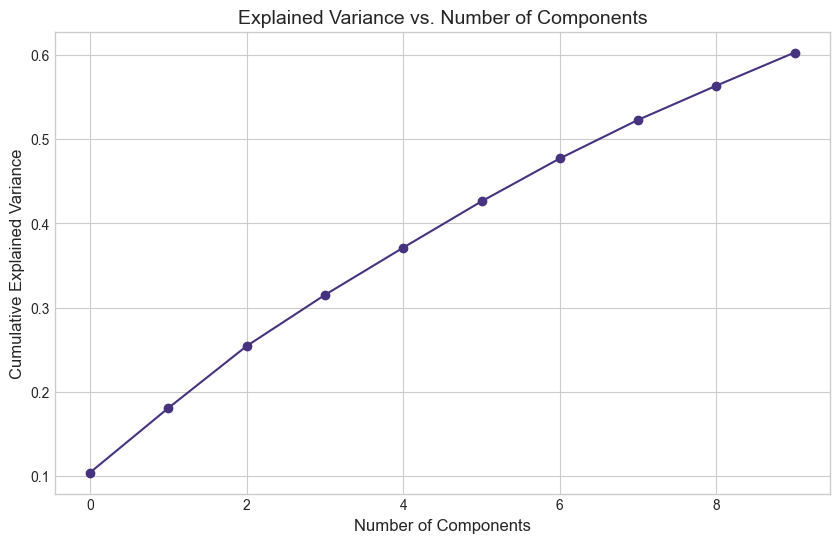

In [386]:
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()


Applying t-SNE for visualization...


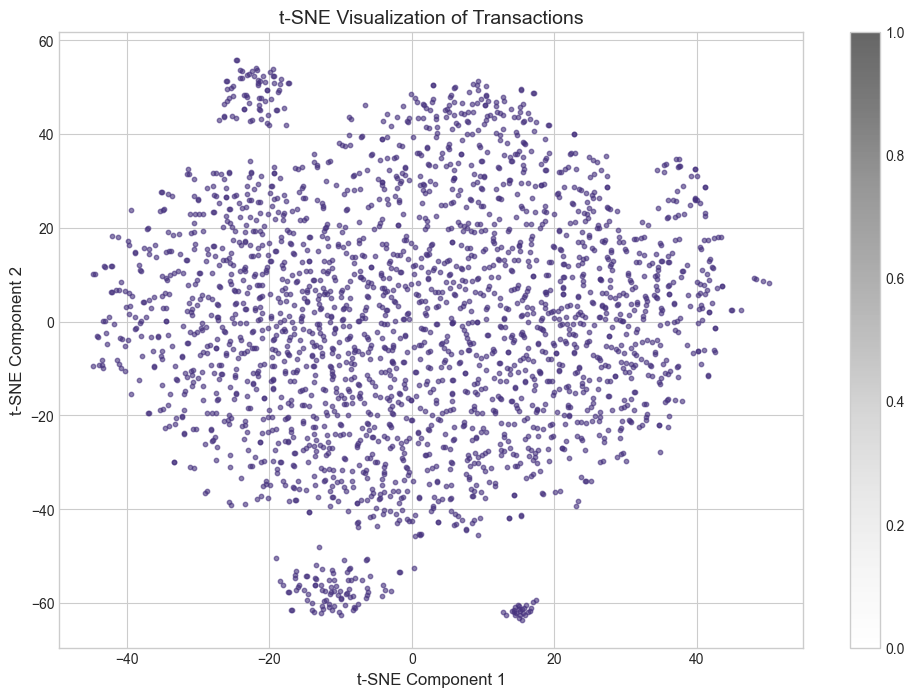

In [387]:
print("\nApplying t-SNE for visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(df_scaled)

plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=10, alpha=0.6)
plt.title('t-SNE Visualization of Transactions')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.show()

<h1 style="text-align: center; background: linear-gradient(to right, #2c3e50, #34495e, #1abc9c, #16a085); color: white; padding: 10px; border-radius: 5px;">
  ANOMALY DETECTION
</h1>

# Isolation Forest

In [388]:
param_grid = {
    'n_estimators': [100, 200, 300],                     # jumlah pohon
    'max_samples': [64, 128, 'auto'],                    # jumlah sampel yang diambil untuk membangun setiap pohon
    'contamination': [0.04, 0.05, 0.06, 0.07],          # proporsi outlier
    'max_features': [0.5, 0.75, 1.0],                         # proporsi fitur yang digunakan di setiap pohon
    'bootstrap': [False, True],                               # apakah sampling dilakukan dengan pengembalian
}

In [389]:
def isolation_score(estimator, X):
    scores = estimator.score_samples(X)
    return np.mean(scores)  # semakin tinggi rata-rata skor, semakin baik pemisahan anomali

custom_scorer = make_scorer(isolation_score, greater_is_better=True)

In [390]:
grid_search = GridSearchCV(
    estimator=IsolationForest(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring=custom_scorer,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(df_scaled)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5, estimator=IsolationForest(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [False, True],
                         'contamination': [0.04, 0.05, 0.06, 0.07],
                         'max_features': [0.5, 0.75, 1.0],
                         'max_samples': [64, 128, 'auto'],
                         'n_estimators': [100, 200, 300]},
             scoring=make_scorer(isolation_score, response_method='predict'),
             verbose=1)

In [391]:
print(f"Best Isolation Forest parameters: {grid_search.best_params_}")
best_iso_forest = grid_search.best_estimator_

Best Isolation Forest parameters: {'bootstrap': False, 'contamination': 0.04, 'max_features': 0.5, 'max_samples': 64, 'n_estimators': 100}


In [392]:
df['IF_Anomaly'] = best_iso_forest.predict(df_scaled)
df['IF_Score'] = best_iso_forest.decision_function(df_scaled)

In [393]:
df['IF_Anomaly'] = df['IF_Anomaly'].map({1: 0, -1: 1})

In [394]:
df['IF_Anomaly'].value_counts()


IF_Anomaly
0    2411
1     101
Name: count, dtype: int64

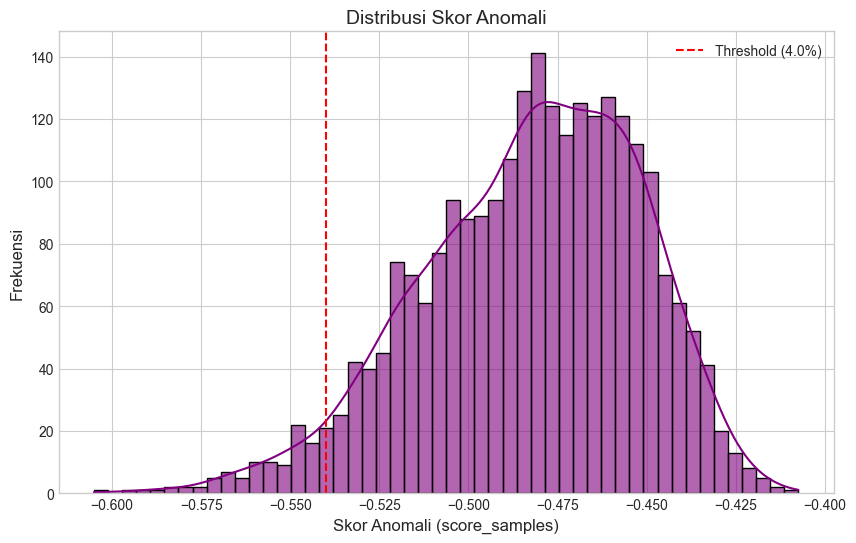

       AnomalyScore
count   2512.000000
mean      -0.482436
std        0.030499
min       -0.605110
25%       -0.502690
50%       -0.479633
75%       -0.459437
max       -0.407387


In [395]:

# Hitung score_samples (semakin kecil => semakin anomali)
scores = best_iso_forest.score_samples(df_scaled)

# Simpan ke dataframe
df_score = pd.DataFrame({
    'AnomalyScore': scores
})

# Hitung threshold berdasarkan skor terendah sesuai contamination
contamination = best_iso_forest.contamination  # atau langsung angka, misal 0.02
threshold = np.percentile(scores, 100 * contamination)

# Visualisasi distribusi skor
plt.figure(figsize=(10, 6))
sns.histplot(df_score['AnomalyScore'], bins=50, kde=True, color='purple', edgecolor='black', alpha=0.6)
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({contamination*100:.1f}%)')
plt.title("Distribusi Skor Anomali")
plt.xlabel("Skor Anomali (score_samples)")
plt.ylabel("Frekuensi")
plt.legend()
plt.show()

# Statistik dasar
print(df_score.describe())


# One-Class SVM

In [396]:
# Grid search untuk One-Class SVM
param_grid_svm = {
    'nu': [0.04, 0.05, 0.07, 0.1],  # Batas atas perkiraan fraksi outlier
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001]
}

In [397]:
# Custom scorer for OCSVM
def ocsvm_score(estimator, X):
    scores = estimator.decision_function(X)
    return -np.mean(scores)  # Nilai yang lebih negatif menunjukkan anomali yang lebih baik terdeteksi


In [398]:
grid_search_svm = GridSearchCV(
    OneClassSVM(), param_grid_svm, cv=5, scoring=make_scorer(ocsvm_score), n_jobs=-1
)
grid_search_svm.fit(df_scaled)

GridSearchCV(cv=5, estimator=OneClassSVM(), n_jobs=-1,
             param_grid={'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
                         'nu': [0.04, 0.05, 0.07, 0.1]},
             scoring=make_scorer(ocsvm_score, response_method='predict'))

In [399]:
print(f"Best Isolation Forest parameters: {grid_search_svm.best_params_}")
best_ocsvm = grid_search_svm.best_estimator_

Best Isolation Forest parameters: {'gamma': 'scale', 'kernel': 'rbf', 'nu': 0.04}


In [400]:
df['OCSVM_Anomaly'] = best_ocsvm.fit_predict(df_scaled)
df['OCSVM_Score'] = best_ocsvm.decision_function(df_scaled)

In [401]:
df['OCSVM_Anomaly'] = df['OCSVM_Anomaly'].map({1: 0, -1: 1})

In [402]:
df['OCSVM_Anomaly'].value_counts()


OCSVM_Anomaly
0    2406
1     106
Name: count, dtype: int64

# Local Outlier Factor

In [403]:


# 1. Definisikan parameter grid
param_grid = {
    'n_neighbors': [5, 10, 20],          # Jumlah tetangga
    'contamination': [0.04, 0.06, 0.08, 0.1],  # Persentase outlier yang diharapkan
    'metric': ['euclidean', 'cosine']    # Jenis jarak
}

In [404]:
# 2. Buat scorer kustom (semakin besar skor semakin baik)
def lof_scorer(estimator, X):
    return -estimator.negative_outlier_factor_.mean()  # Konversi ke positif

custom_scorer = make_scorer(lof_scorer, greater_is_better=True)

# 3. Jalankan Grid Search
grid_search = GridSearchCV(
    estimator=LocalOutlierFactor(novelty=False),  # novelty=False untuk fit_predict
    param_grid=param_grid,
    scoring=custom_scorer,
    cv=3,           # 3-fold cross-validation
    verbose=1,
    n_jobs=-1       # Gunakan semua core CPU
)

grid_search.fit(df_scaled)  # Gunakan data yang sudah di-scale

# 4. Hasil terbaik
print(f"\nParameter LOF terbaik: {grid_search.best_params_}")
best_lof = grid_search.best_estimator_

# 5. Terapkan ke data
df['LOF_Anomaly'] = best_lof.fit_predict(df_scaled)
df['LOF_Score'] = -best_lof.negative_outlier_factor_  # Konversi ke skor positif

Fitting 3 folds for each of 24 candidates, totalling 72 fits

Parameter LOF terbaik: {'contamination': 0.04, 'metric': 'euclidean', 'n_neighbors': 5}


In [405]:
df['LOF_Anomaly'] = df['LOF_Anomaly'].map({1: 0, -1: 1})
df['LOF_Anomaly'].value_counts()

LOF_Anomaly
0    2411
1     101
Name: count, dtype: int64

# Mahalanobis

In [407]:
# Hitung mean dan inverse covariance matrix dari data yang sudah diskalakan
mean_vec = np.mean(df_scaled, axis=0)
cov_matrix = np.cov(df_scaled, rowvar=False)
cov_matrix_inv = np.linalg.pinv(cov_matrix)


# Hitung Mahalanobis distance untuk setiap data point
mahalanobis_scores = np.array([mahalanobis(x, mean_vec, cov_matrix_inv) for x in df_scaled])
df['M_Score'] = mahalanobis_scores

# Tentukan threshold top 4%
threshold = np.percentile(df['M_Score'], 96)
df['M_Anomaly'] = (df['M_Score'] > threshold).astype(int)

print("\nmahalanobis Distance Results:")
print(f"Threshold (96th percentile): {threshold:.4f}")
print(df['M_Anomaly'].value_counts())



mahalanobis Distance Results:
Threshold (96th percentile): 8.0042
M_Anomaly
0    2411
1     101
Name: count, dtype: int64


# Histogram-based Outlier Score

In [408]:
# 2. HBOS (Histogram-based Outlier Score)
hbos = HBOS()
hbos.fit(df_scaled)
df['HBOS_Score'] = hbos.decision_scores_  # semakin besar semakin anomali
threshold = np.percentile(df['HBOS_Score'], 96)
df['HBOS_Anomaly'] = (df['HBOS_Score'] > threshold).astype(int)
print("M anomalies:", df['HBOS_Anomaly'].sum())

print("\nHistogram-based Outlier Score Distance Results:")
print(f"Threshold (96th percentile): {threshold:.4f}")
print(df['HBOS_Anomaly'].value_counts())

M anomalies: 101

Histogram-based Outlier Score Distance Results:
Threshold (96th percentile): 33.2746
HBOS_Anomaly
0    2411
1     101
Name: count, dtype: int64


# GaussianMixture

In [409]:
# Fit GMM
gmm = GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gmm.fit(df_scaled)

# Hitung log-likelihood
df['GMM_Score'] = -gmm.score_samples(df_scaled) 

# Tentukan threshold (top 4%)
threshold = np.percentile(df['GMM_Score'], 96)
df['GMM_Anomaly'] = (df['GMM_Score'] > threshold).astype(int)

print("\nGMM Results:")
print(f"Threshold (95th percentile): {threshold:.4f}")
print(df['GMM_Anomaly'].value_counts())


GMM Results:
Threshold (95th percentile): 22.4719
GMM_Anomaly
0    2411
1     101
Name: count, dtype: int64


In [410]:


# Hitung jarak ke k-tetangga terdekat
n_neighbors = 5
nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(df_scaled)
distances, _ = nbrs.kneighbors(df_scaled)

# Skor anomali = rata-rata jarak ke k-tetangga
df['kNN_Score'] = distances.mean(axis=1)

# Tentukan threshold (top 5%)
threshold = np.percentile(df['kNN_Score'], 96)
df['kNN_Anomaly'] = (df['kNN_Score'] > threshold).astype(int)

print("\nk-NN Anomaly Results:")
print(f"Threshold: {threshold:.4f}")
print(f"Anomalies: {df['kNN_Anomaly'].sum()} ({df['kNN_Anomaly'].mean()*100:.2f}%)")


k-NN Anomaly Results:
Threshold: 4.1486
Anomalies: 101 (4.02%)


# Model Evaluations

In [411]:
models_config = [
    {'name': 'Isolation Forest', 'col': 'IF_Anomaly'},
    {'name': 'One-Class SVM', 'col': 'OCSVM_Anomaly'},
    {'name': 'Local Outlier Factor', 'col': 'LOF_Anomaly'},
    {'name': 'Mahalanobis', 'col': 'M_Anomaly'},
    {'name': 'HBOS Mixture', 'col': 'HBOS_Anomaly'},
    {'name': 'Gaussian Mixture', 'col': 'GMM_Anomaly'},
    {'name': 'k-Nearest Neighbors', 'col': 'kNN_Anomaly'},
    {'name': 'Ensemble', 'col': 'Ensemble_Anomaly'}
]

In [412]:
print("\nAnomaly counts by each method:")
for model in models_config:
    if model['name'] == 'Ensemble':
        continue
    col = model['col'] 
    total = df[col].sum()
    persen = df[col].mean() * 100
    print(f"{model['name']}: {total} ({persen:.2f}%)")



Anomaly counts by each method:
Isolation Forest: 101 (4.02%)
One-Class SVM: 106 (4.22%)
Local Outlier Factor: 101 (4.02%)
Mahalanobis: 101 (4.02%)
HBOS Mixture: 101 (4.02%)
Gaussian Mixture: 101 (4.02%)
k-Nearest Neighbors: 101 (4.02%)


In [413]:
threshold_minimal = 4

# Ambil nama-nama kolom anomaly dari models_config, kecuali 'Ensemble_Anomaly'
anomaly_cols = [m['col'] for m in models_config if m['col'] != 'Ensemble_Anomaly']

# Hitung jumlah model yang mendeteksi anomali, lalu bandingkan dengan threshold
df['Ensemble_Anomaly'] = (df[anomaly_cols].sum(axis=1) >= threshold_minimal).astype(int)

In [414]:
# 1. Kontribusi Anomali per Model
print("Kontribusi Anomali per Model (1=Anomali, 0=Normal):")
print("="*60)
for model in models_config[:-1]:  # Exclude ensemble
    n_anomalies = df[model['col']].sum()
    total = len(df)
    print(f"{model['name']:<25}: {n_anomalies}/{total} ({n_anomalies/total*100:.2f}%)")

# 3. Hasil Ensemble
print(f"\nHasil Ensemble (Threshold ≥{threshold_minimal}):")
print("="*60)
print(f"Total Anomali  : {df['Ensemble_Anomaly'].sum()}/{total} ({df['Ensemble_Anomaly'].mean()*100:.2f}%)")
print(f"Total Normal   : {(df['Ensemble_Anomaly'] == 0).sum()}/{total} ({(df['Ensemble_Anomaly'] == 0).mean()*100:.2f}%)")

Kontribusi Anomali per Model (1=Anomali, 0=Normal):
Isolation Forest         : 101/2512 (4.02%)
One-Class SVM            : 106/2512 (4.22%)
Local Outlier Factor     : 101/2512 (4.02%)
Mahalanobis              : 101/2512 (4.02%)
HBOS Mixture             : 101/2512 (4.02%)
Gaussian Mixture         : 101/2512 (4.02%)
k-Nearest Neighbors      : 101/2512 (4.02%)

Hasil Ensemble (Threshold ≥4):
Total Anomali  : 59/2512 (2.35%)
Total Normal   : 2453/2512 (97.65%)


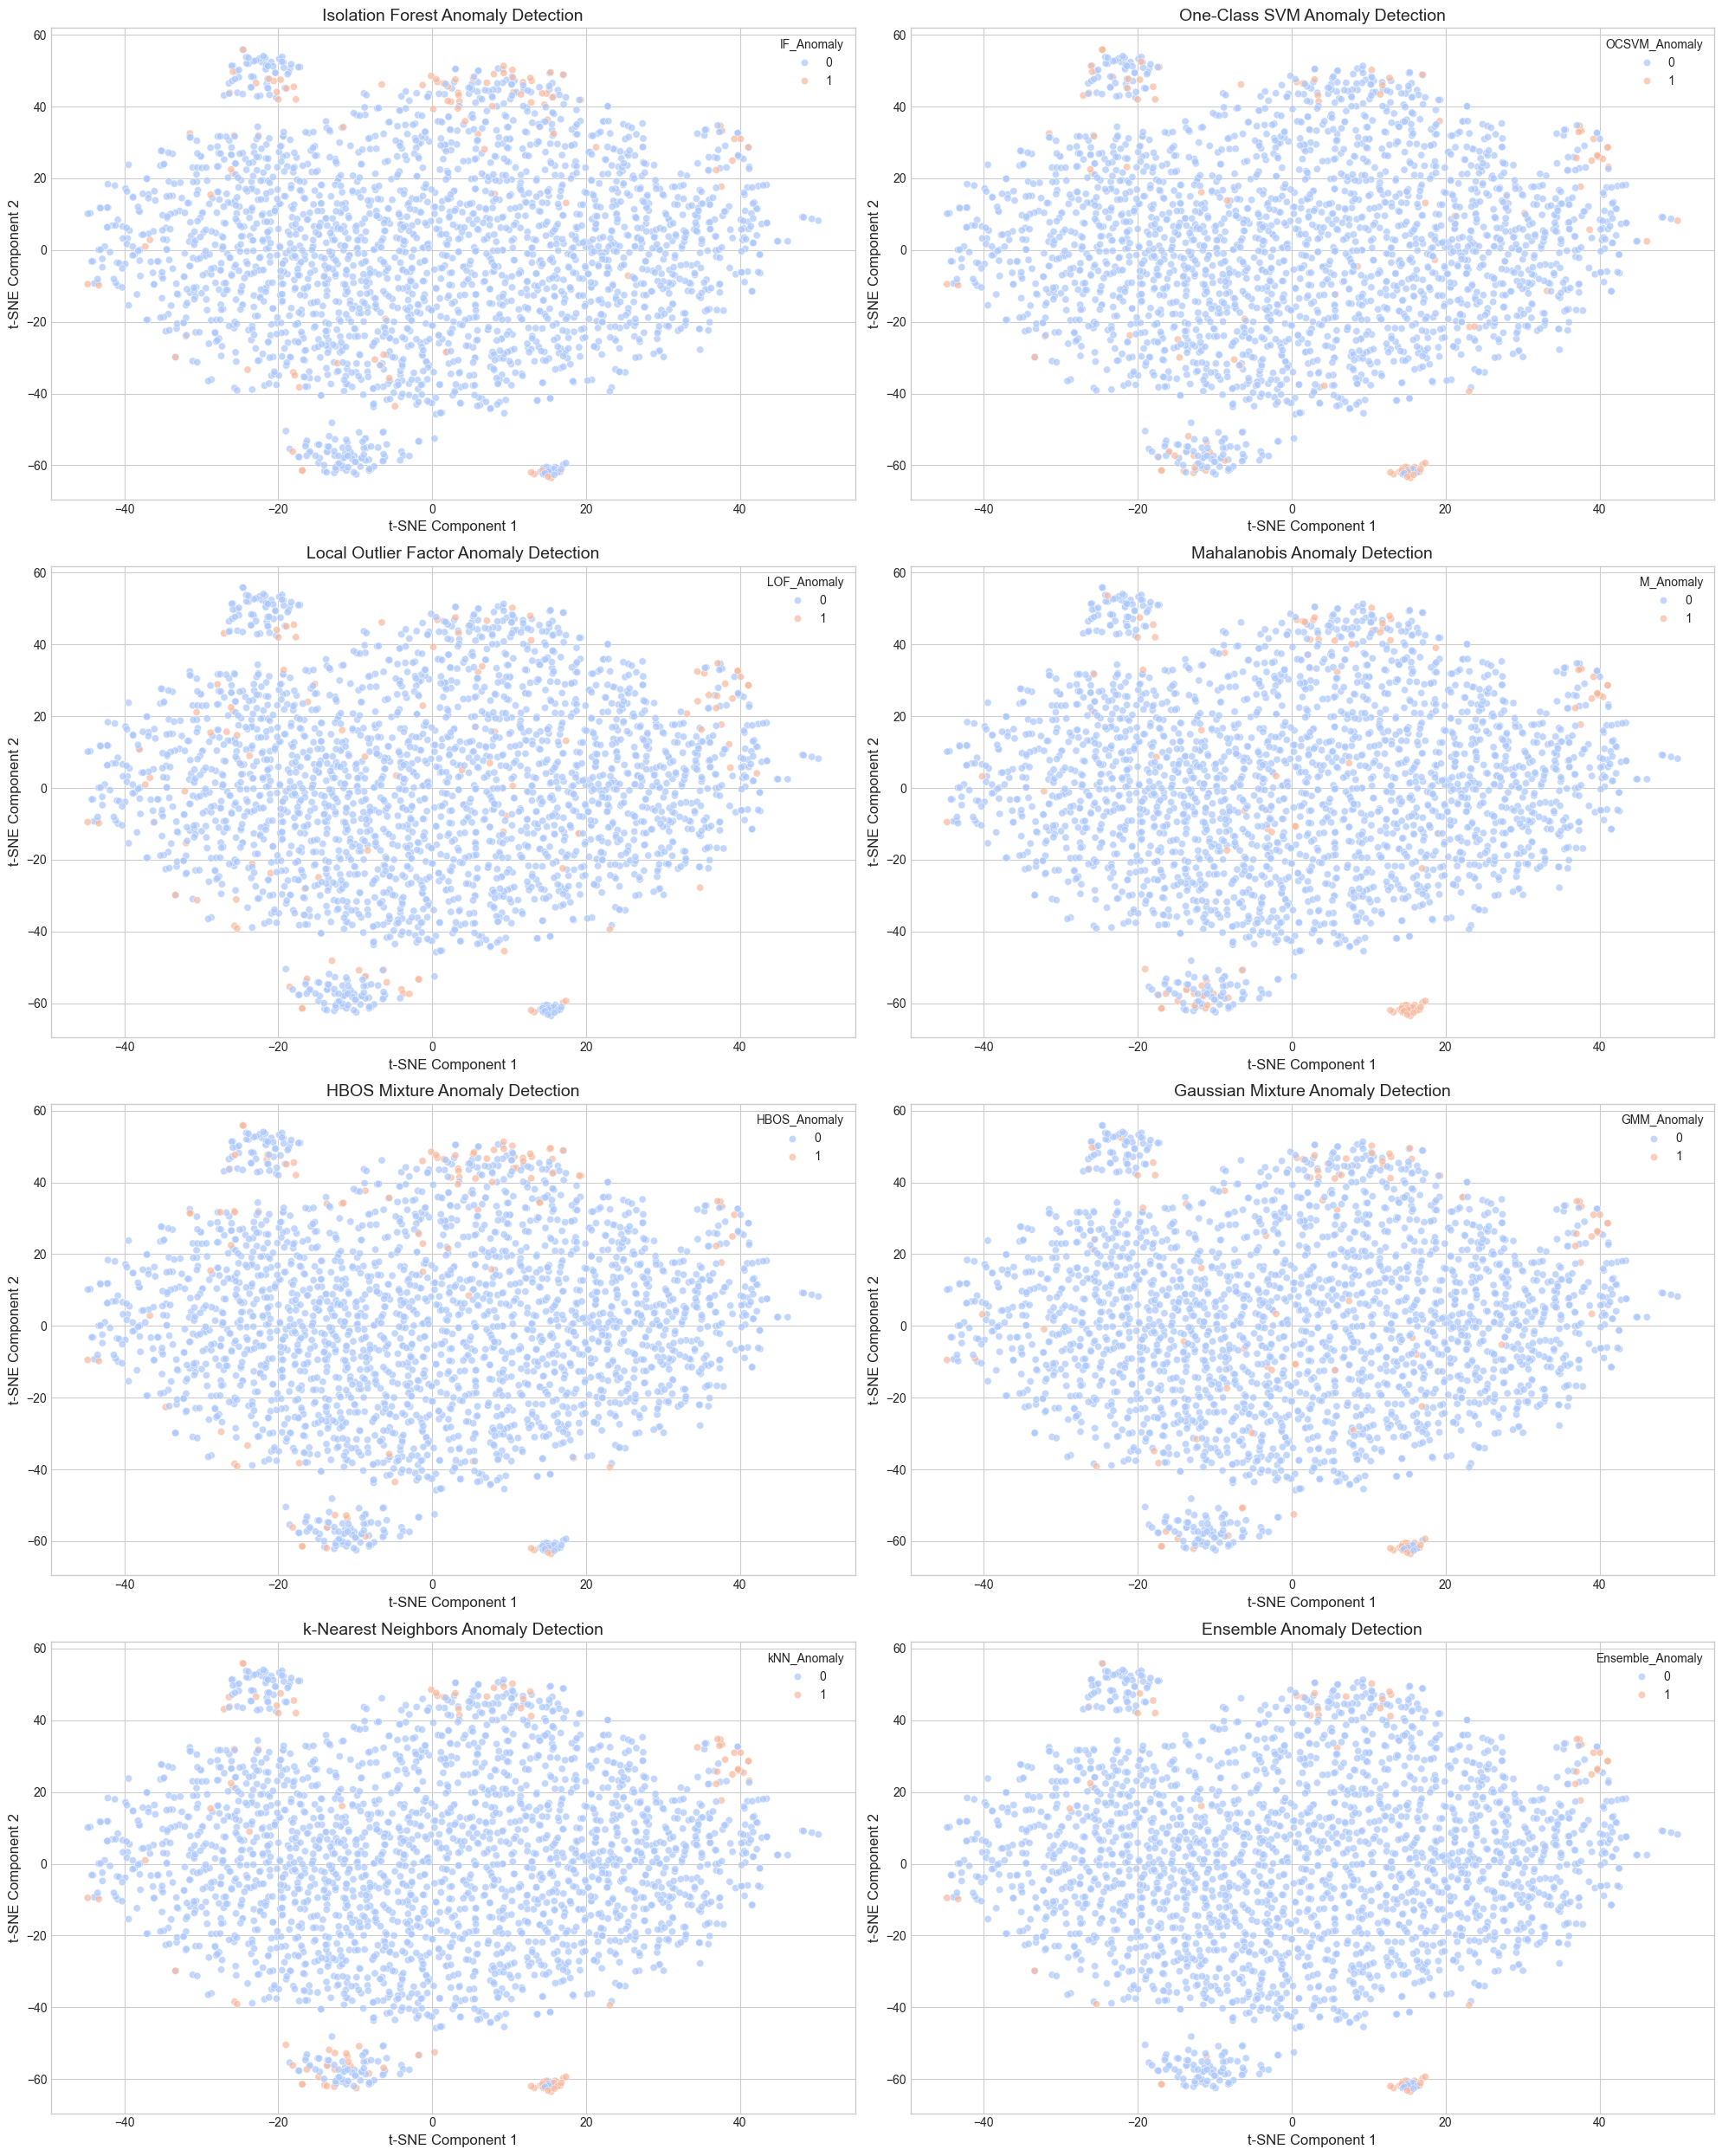

In [415]:
plt.figure(figsize=(20, 25))

for i, model in enumerate(models_config, 1):
    plt.subplot(4, 2, i)
    if model['col'] in df.columns:
        sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], 
                       hue=df[model['col']], palette='coolwarm', alpha=0.7)
        plt.title(f"{model['name']} Anomaly Detection")  
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
    else:
        plt.text(0.5, 0.5, f'Kolom {col} tidak ditemukan', 
                ha='center', va='center')
        plt.title(f'{title} - Data Tidak Tersedia')

plt.tight_layout()
plt.show()

In [416]:
anomalies = df[df['Ensemble_Anomaly'] == 1]
normal = df[df['Ensemble_Anomaly'] == 0]

print(f"\nTotal anomalies: {len(anomalies)}")
print(f"Anomaly percentage: {len(anomalies) / len(df) * 100:.2f}%")


Total anomalies: 59
Anomaly percentage: 2.35%


# Compare transaction amounts

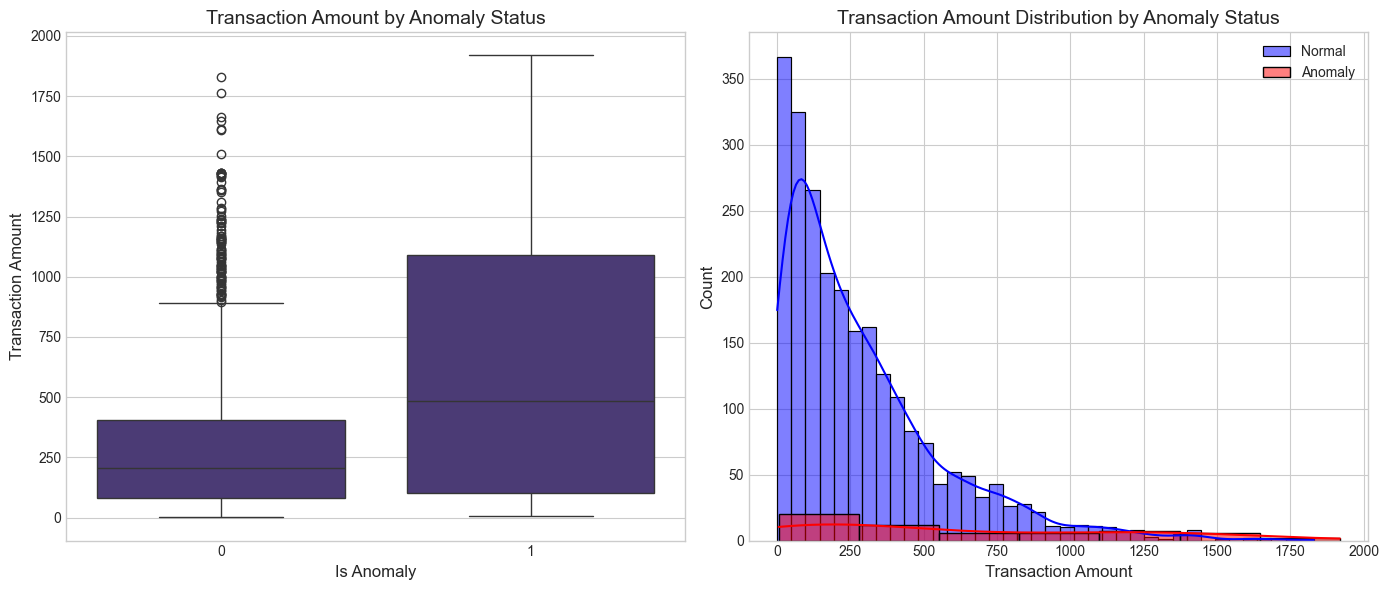

In [417]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Ensemble_Anomaly', y='TransactionAmount', data=df)
plt.title('Transaction Amount by Anomaly Status')
plt.xlabel('Is Anomaly')
plt.ylabel('Transaction Amount')

plt.subplot(1, 2, 2)
sns.histplot(normal['TransactionAmount'], color='blue', alpha=0.5, label='Normal', kde=True)
sns.histplot(anomalies['TransactionAmount'], color='red', alpha=0.5, label='Anomaly', kde=True)
plt.title('Transaction Amount Distribution by Anomaly Status')
plt.xlabel('Transaction Amount')
plt.legend()
plt.tight_layout()
plt.show()

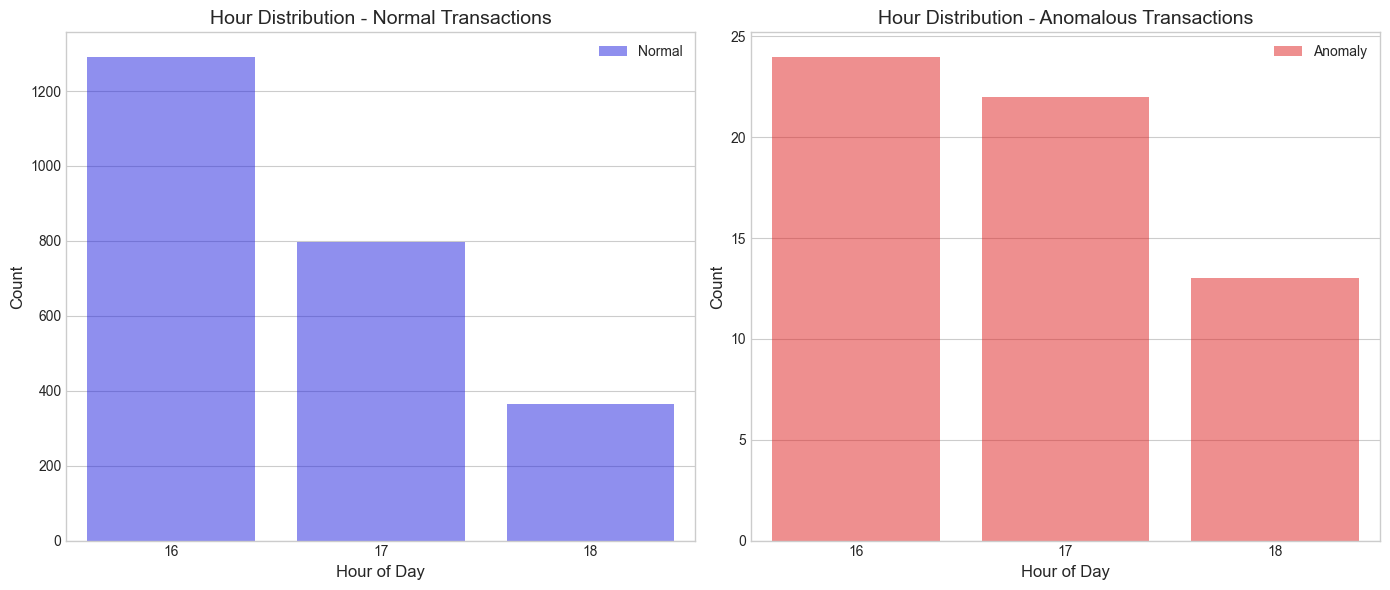

In [418]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(x='Hour', data=normal, color='blue', alpha=0.5, label='Normal')
plt.title('Hour Distribution - Normal Transactions')
plt.xlabel('Hour of Day')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.countplot(x='Hour', data=anomalies, color='red', alpha=0.5, label='Anomaly')
plt.title('Hour Distribution - Anomalous Transactions')
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

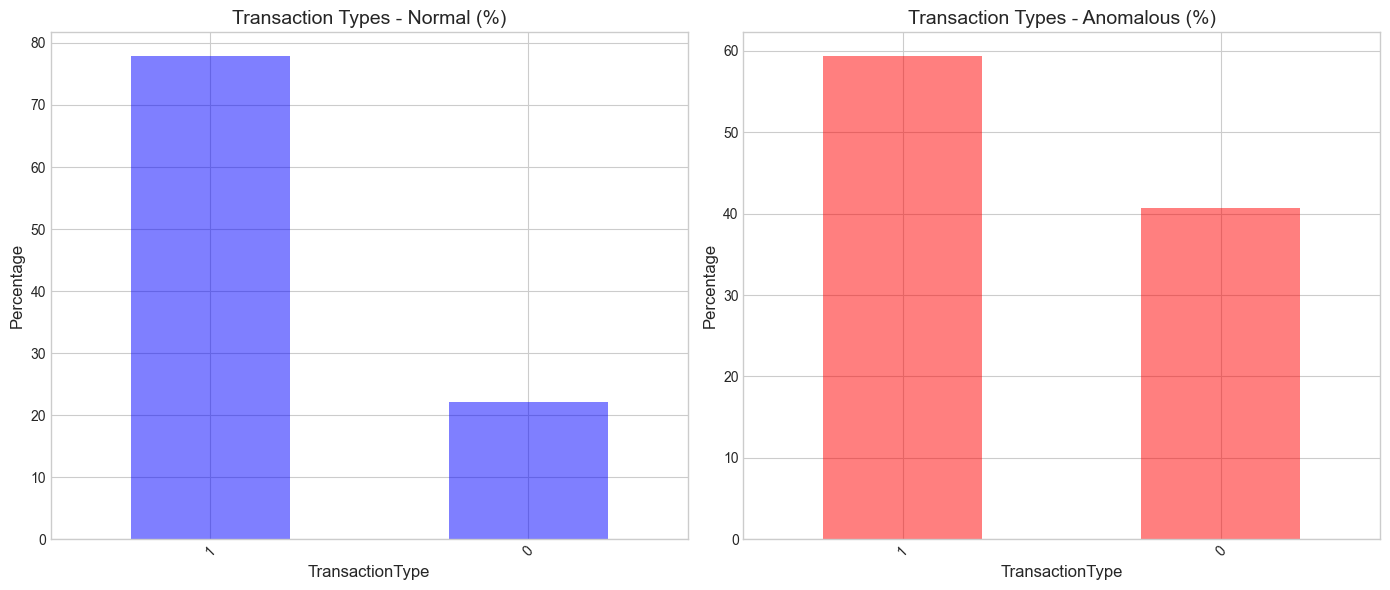

In [419]:
plt.figure(figsize=(14, 6))
normal_tx_type = normal['TransactionType'].value_counts(normalize=True) * 100
anomaly_tx_type = anomalies['TransactionType'].value_counts(normalize=True) * 100

plt.subplot(1, 2, 1)
normal_tx_type.plot(kind='bar', color='blue', alpha=0.5)
plt.title('Transaction Types - Normal (%)')
plt.ylabel('Percentage')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
anomaly_tx_type.plot(kind='bar', color='red', alpha=0.5)
plt.title('Transaction Types - Anomalous (%)')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

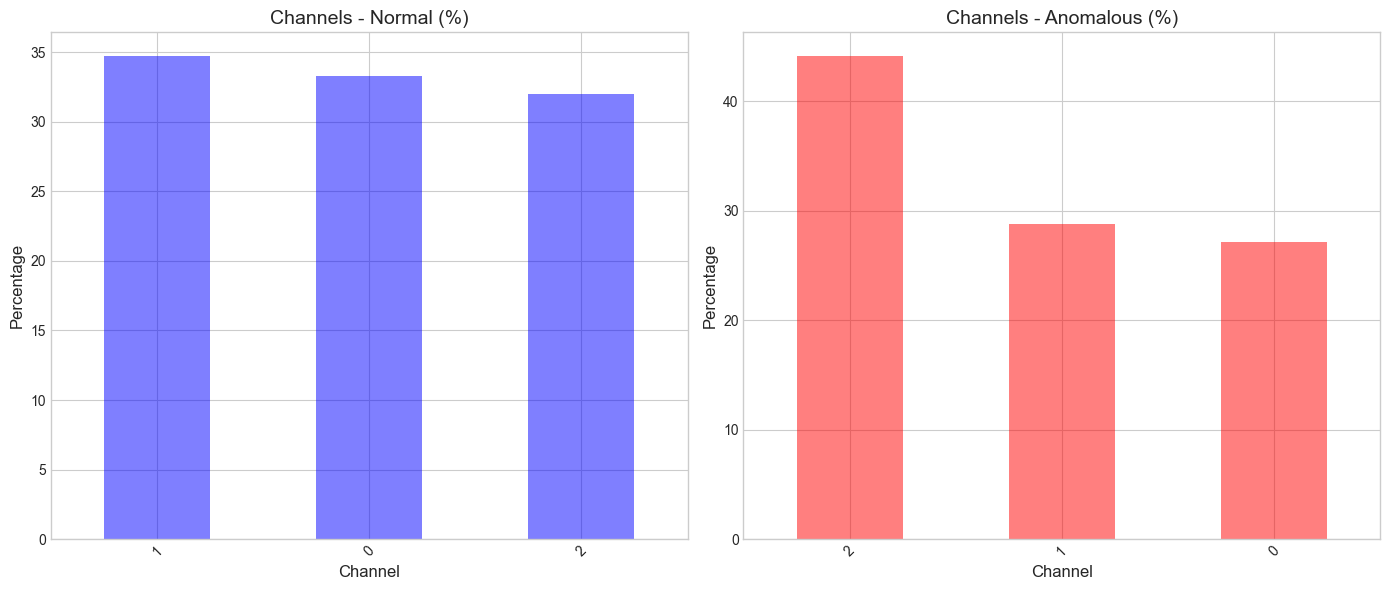

In [420]:
plt.figure(figsize=(14, 6))
normal_channel = normal['Channel'].value_counts(normalize=True) * 100
anomaly_channel = anomalies['Channel'].value_counts(normalize=True) * 100

plt.subplot(1, 2, 1)
normal_channel.plot(kind='bar', color='blue', alpha=0.5)
plt.title('Channels - Normal (%)')
plt.ylabel('Percentage')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
anomaly_channel.plot(kind='bar', color='red', alpha=0.5)
plt.title('Channels - Anomalous (%)')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [421]:
# Fitur: semua kolom kecuali yang terkait model individual dan skor
drop_cols = [col['col'] for col in models_config[:-1]] + [
    'IF_Score', 'OCSVM_Score', 'LOF_Score', 'DistanceCentroid',
    'Composite_Score', 'kNN_Score', 'GMM_Score', 'M_Score', 'HBOS_Score', 'Ensemble_Anomaly'
]
X = df.drop(columns=drop_cols, errors='ignore')

# Label: hasil ensemble
y = df['Ensemble_Anomaly']

# Pelatihan model Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)


RandomForestClassifier(random_state=42)

In [422]:
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop features for distinguishing anomalies:")
print(feature_importances.head(10))


Top features for distinguishing anomalies:
                      Feature  Importance
23          AccountTxVelocity    0.100297
14            TimeSinceLastTx    0.080747
25                   Velocity    0.077560
0           TransactionAmount    0.067662
19  Amount_to_AvgByType_Ratio    0.060155
17           AccountStdAmount    0.048086
16           AccountAvgAmount    0.047473
26        UnrealisticVelocity    0.045401
21    AccountAvgTimeBetweenTx    0.040194
18        TxToAccountAvgRatio    0.037746


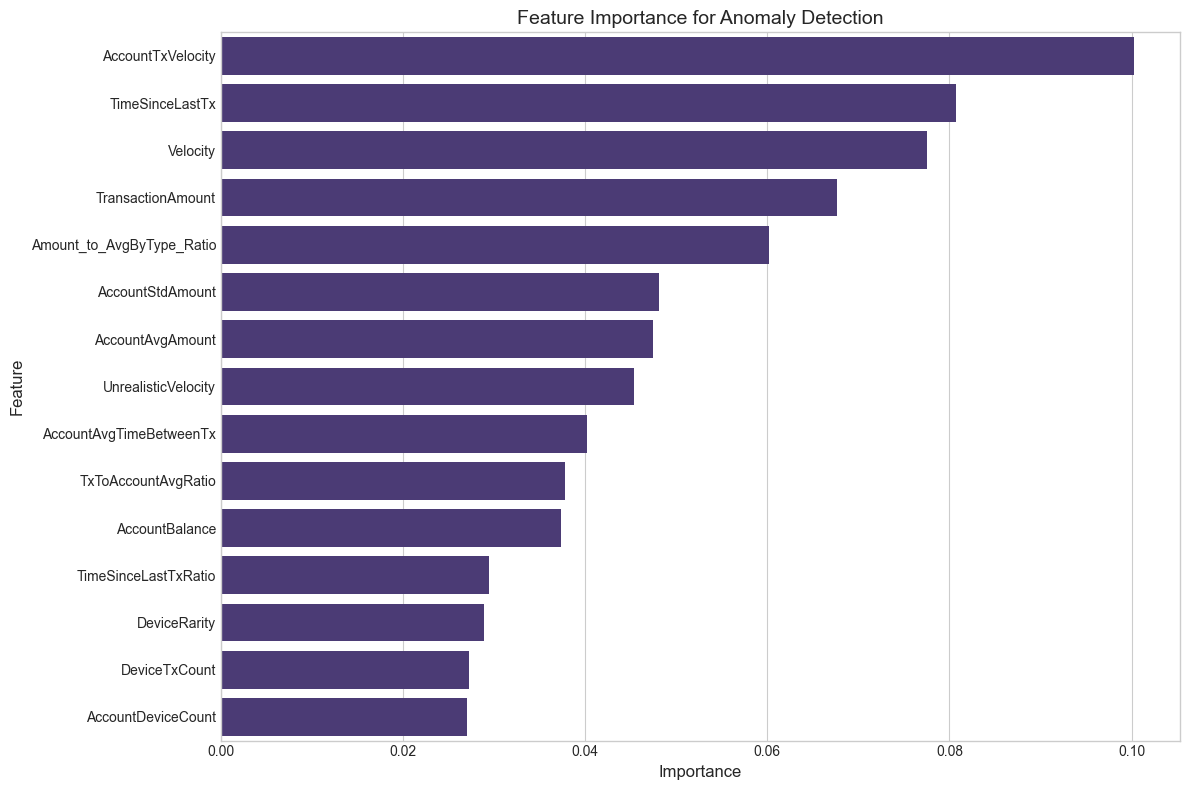

In [423]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15))
plt.title('Feature Importance for Anomaly Detection')
plt.tight_layout()
plt.show()

In [424]:
score_columns = [
    ('IF_Score', 'IF_Score_Norm'),
    ('OCSVM_Score', 'OCSVM_Score_Norm'), 
    ('LOF_Score', 'LOF_Score_Norm'),
    ('M_Score', 'M_Score_Norm'),
    ('HBOS_Score', 'HBOS_Score_Norm'),
    ('GMM_Score', 'GMM_Score_Norm'),
    ('kNN_Score', 'kNN_Score_Norm'),
    
]

# 2. Normalisasi semua skor sekaligus
for input_col, output_col in score_columns:
    if input_col in df.columns:
        scaler = MinMaxScaler()
        # Normalisasi dengan inversi karena skor lebih besar = lebih anomali
        df[output_col] = scaler.fit_transform(-df[[input_col]])
    else:
        print(f"Peringatan: Kolom {input_col} tidak ditemukan")

In [425]:
norm_column = [norm for _, norm in score_columns]
df['Composite_Score'] = PCA(n_components=1).fit_transform(df[norm_column])


In [426]:
df_model = df.sort_values('Composite_Score', ascending=False)

print("\nTop 20 Most Anomalous Transactions:")
top_anomalies = df_model.head(20).reset_index(drop=True)
# Ambil semua kolom anomali dari models_config, kecuali 'Ensemble'
anomaly_cols = [model['col'] for model in models_config if model['col'] != 'Ensemble_Anomaly']
anomaly_cols += ['Ensemble_Anomaly', 'Composite_Score']

top_anomalies[anomaly_cols]


Top 20 Most Anomalous Transactions:


IF_Anomaly  OCSVM_Anomaly  LOF_Anomaly  M_Anomaly  HBOS_Anomaly  \
0            1              1            1          1             1   
1            1              1            1          1             0   
2            1              1            0          1             1   
3            1              1            1          0             1   
4            1              1            1          1             1   
5            0              1            1          1             0   
6            0              1            1          1             0   
7            1              1            0          0             1   
8            1              0            0          1             1   
9            1              1            1          1             1   
10           1              1            1          1             1   
11           1              1            1          1             1   
12           1              0            1          1             1   
13           1              1            0          1             1   
14           1              0            1          1             1   
15           1              1            1          1             0   
16           1              1            1          1             1   
17           1              1            1          1             1   
18           1              1            1          1             1   
19           1              1            0          1             1   

    GMM_Anomaly  kNN_Anomaly  Ensemble_Anomaly  Composite_Score  
0             1            1                 1         1.046433  
1             1            1                 1         0.935892  
2             1            1                 1         0.901900  
3             1            1                 1         0.878210  
4             1            1                 1         0.875998  
5             1            1                 1         0.859202  
6             1            1                 1         0.845303  
7             1            1                 1         0.800278  
8             1            0                 1         0.795690  
9             1            1                 1         0.794747  
10            1            1                 1         0.793473  
11            1            1                 1         0.779362  
12            1            1                 1         0.773586  
13            1            1                 1         0.772718  
14            1            1                 1         0.771468  
15            1            1                 1         0.766587  
16            1            1                 1         0.750960  
17            1            1                 1         0.750406  
18            1            1                 1         0.749829  
19            1            1                 1         0.728385

In [427]:
df_anomali = df[df['Ensemble_Anomaly'] == 1].copy()

In [428]:
len(df_anomali)

59

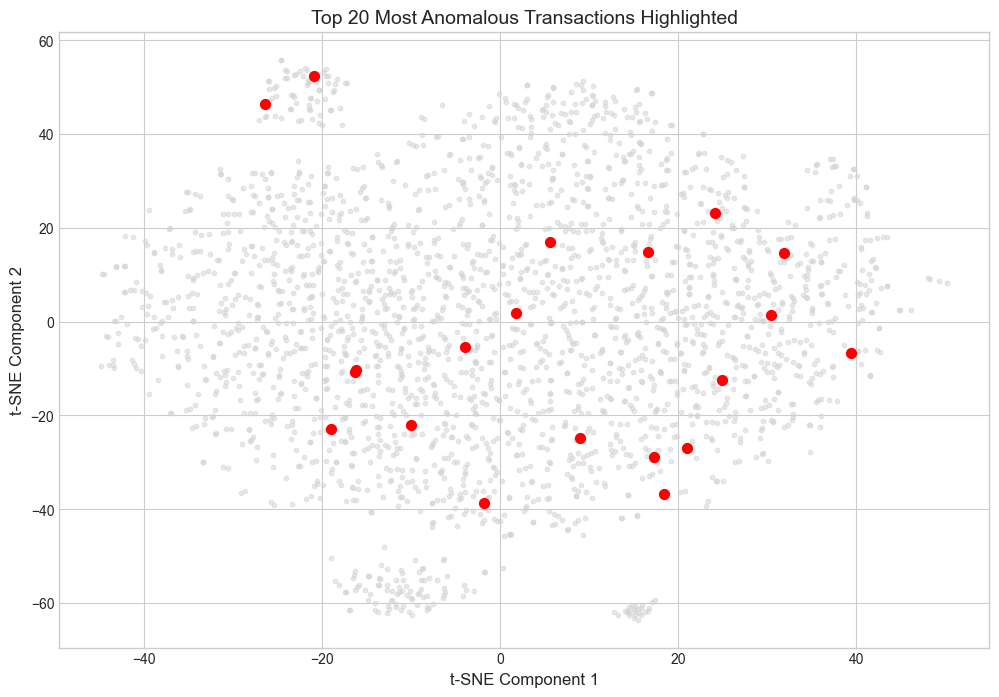

In [429]:
top_indices = top_anomalies.index
plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=10, c='lightgray', alpha=0.5)
plt.scatter(tsne_results[top_indices, 0], tsne_results[top_indices, 1], s=50, c='red', marker='o')
plt.title('Top 20 Most Anomalous Transactions Highlighted')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

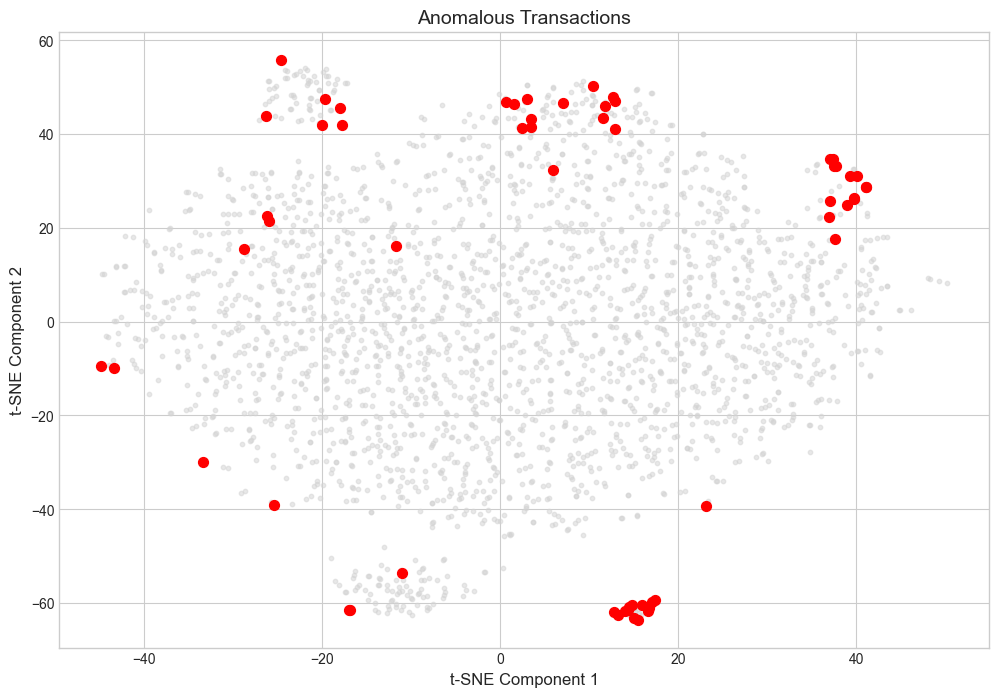

In [430]:
top_indices = df_anomali.index
plt.figure(figsize=(12, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=10, c='lightgray', alpha=0.5)
plt.scatter(tsne_results[top_indices, 0], tsne_results[top_indices, 1], s=50, c='red', marker='o')
plt.title('Anomalous Transactions')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

In [431]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X, y)

DecisionTreeClassifier(max_depth=5, random_state=42)

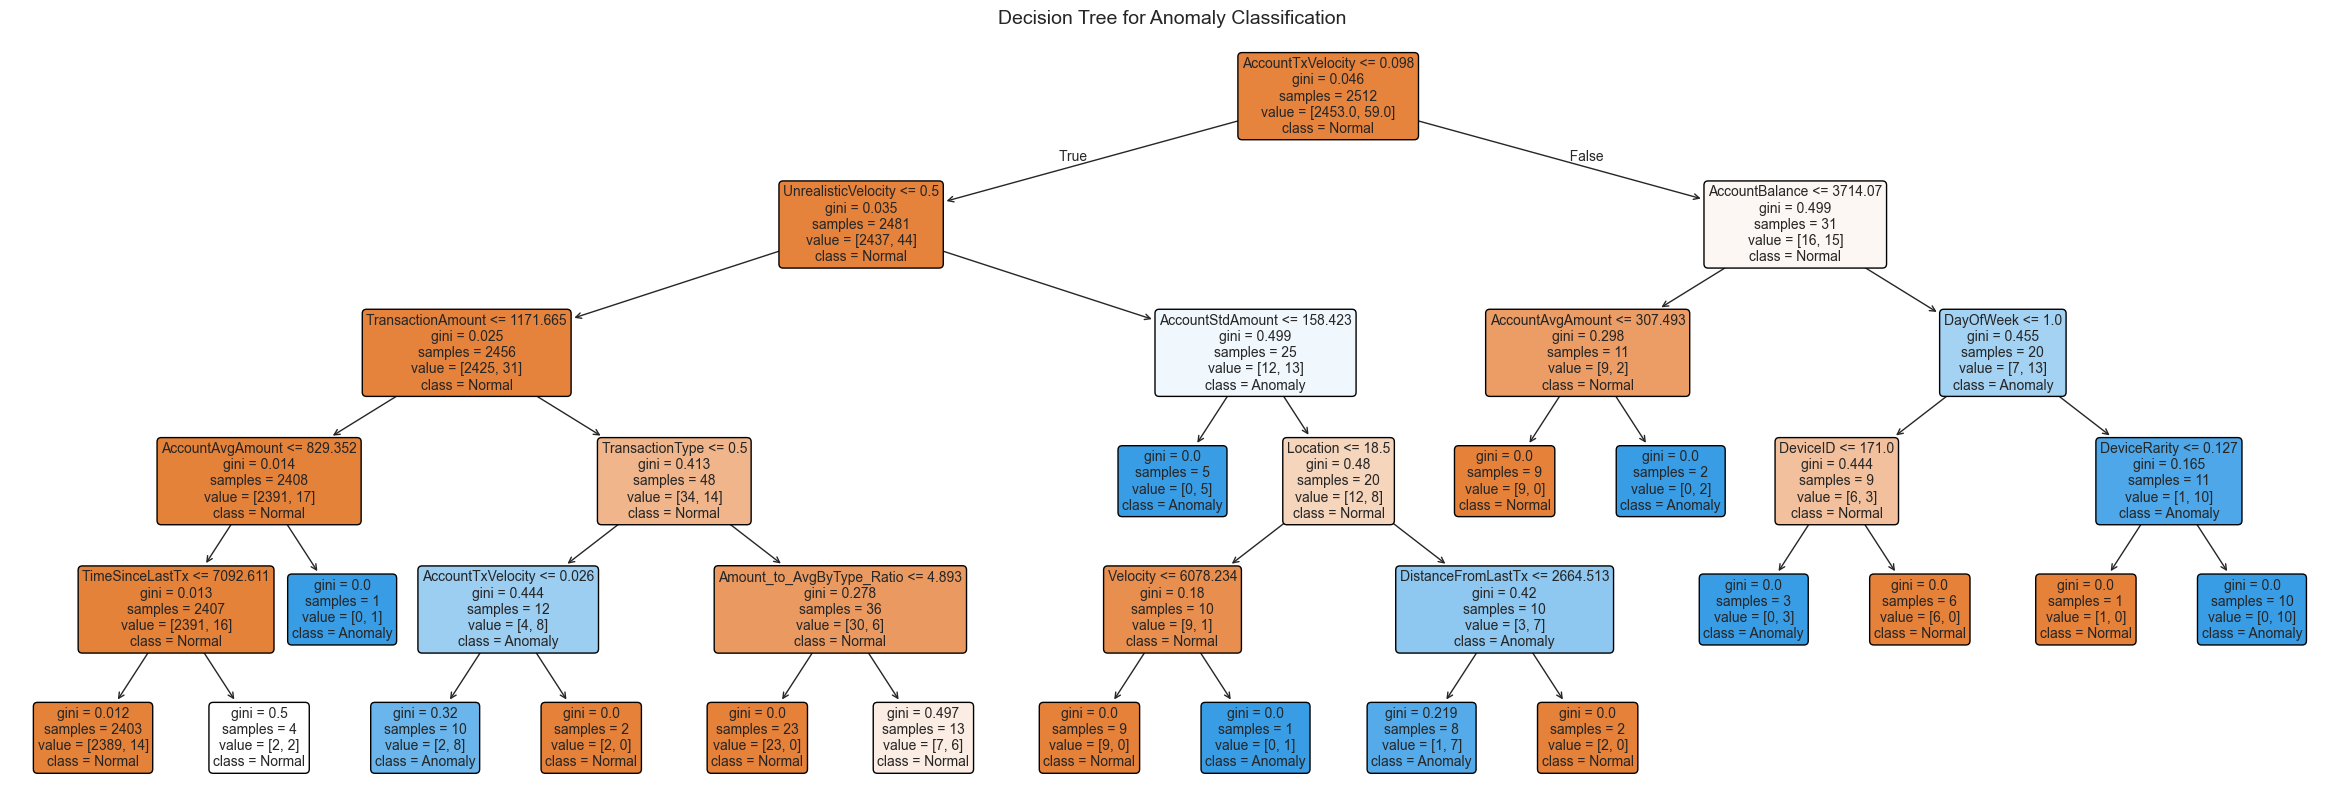

In [432]:
plt.figure(figsize=(30, 10))
plot_tree(dt, filled=True, feature_names=X.columns, class_names=['Normal', 'Anomaly'], rounded=True, fontsize=10)
plt.title('Decision Tree for Anomaly Classification')
plt.show()

In [433]:
print("\nDecision Rules for Identifying Anomalies:")
rules = export_text(dt, feature_names=list(X.columns))
print(rules)


Decision Rules for Identifying Anomalies:
|--- AccountTxVelocity <= 0.10
|   |--- UnrealisticVelocity <= 0.50
|   |   |--- TransactionAmount <= 1171.66
|   |   |   |--- AccountAvgAmount <= 829.35
|   |   |   |   |--- TimeSinceLastTx <= 7092.61
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- TimeSinceLastTx >  7092.61
|   |   |   |   |   |--- class: 0
|   |   |   |--- AccountAvgAmount >  829.35
|   |   |   |   |--- class: 1
|   |   |--- TransactionAmount >  1171.66
|   |   |   |--- TransactionType <= 0.50
|   |   |   |   |--- AccountTxVelocity <= 0.03
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- AccountTxVelocity >  0.03
|   |   |   |   |   |--- class: 0
|   |   |   |--- TransactionType >  0.50
|   |   |   |   |--- Amount_to_AvgByType_Ratio <= 4.89
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Amount_to_AvgByType_Ratio >  4.89
|   |   |   |   |   |--- class: 0
|   |--- UnrealisticVelocity >  0.50
|   |   |--- AccountStdAmount <= 158.42
|   |   |   |--- class: 

In [434]:
print("\nAnomaly Rate by Transaction Type:")
tx_type_anomaly = df_model.groupby('TransactionType')['Ensemble_Anomaly'].mean() * 100
print(tx_type_anomaly.sort_values(ascending=False))

print("\nAnomaly Rate by Hour:")
hour_anomaly = df_model.groupby('Hour')['Ensemble_Anomaly'].mean() * 100
print(hour_anomaly.sort_values(ascending=False))

print("\nAnomaly Rate by Channel:")
channel_anomaly = df_model.groupby('Channel')['Ensemble_Anomaly'].mean() * 100
print(channel_anomaly.sort_values(ascending=False))

print("\nAnomaly Rate by Day of Week:")
dow_anomaly = df_model.groupby('DayOfWeek')['Ensemble_Anomaly'].mean() * 100
print(dow_anomaly.sort_values(ascending=False))


Anomaly Rate by Transaction Type:
TransactionType
0    4.225352
1    1.800412
Name: Ensemble_Anomaly, dtype: float64

Anomaly Rate by Hour:
Hour
18    3.448276
17    2.686203
16    1.823708
Name: Ensemble_Anomaly, dtype: float64

Anomaly Rate by Channel:
Channel
2    3.205919
1    1.958525
0    1.920768
Name: Ensemble_Anomaly, dtype: float64

Anomaly Rate by Day of Week:
DayOfWeek
2    2.932551
4    2.680965
0    2.242991
3    2.173913
1    1.944444
Name: Ensemble_Anomaly, dtype: float64


In [435]:
# Analisis karakteristik anomali lebih mendalam
def analyze_anomaly_patterns(df):
    anomalies = df[df['Ensemble_Anomaly'] == 1]
    normal = df[df['Ensemble_Anomaly'] == 0]
    
    # Pola waktu
    print("==== Pola Waktu Anomali ====")
    time_analysis = pd.DataFrame({
        'Normal (%)': normal['Hour'].value_counts(normalize=True) * 100,
        'Anomali (%)': anomalies['Hour'].value_counts(normalize=True) * 100
    }).fillna(0)
    
    print(time_analysis.sort_values('Anomali (%)', ascending=False).head(5))
    
    # Pola nilai transaksi
    print("\n==== Statistik Nilai Transaksi ====")
    print("Normal transactions:")
    print(normal['TransactionAmount'].describe())
    print("\nAnomalous transactions:")
    print(anomalies['TransactionAmount'].describe())
    
    # Kombinasi faktor untuk kasus anomali
    return

analyze_anomaly_patterns(df)

==== Pola Waktu Anomali ====
      Normal (%)  Anomali (%)
Hour                         
16     52.670200    40.677966
17     32.490828    37.288136
18     14.838973    22.033898

==== Statistik Nilai Transaksi ====
Normal transactions:
count    2453.000000
mean      289.758161
std       277.984808
min         0.260000
25%        81.510000
50%       207.820000
75%       406.810000
max      1830.000000
Name: TransactionAmount, dtype: float64

Anomalous transactions:
count      59.000000
mean      623.369492
std       559.050270
min         5.290000
25%       103.345000
50%       484.300000
75%      1088.840000
max      1919.110000
Name: TransactionAmount, dtype: float64


In [436]:
# Kriteria anomali domain
velocity_threshold = 800
amount_std_multiplier = 3
device_threshold = 5
tx_velocity_quantile = 0.95

# Terapkan kriteria
impossible_travel = df['Velocity'] > velocity_threshold
unusual_amount = df['TxToAccountAvgRatio'] > amount_std_multiplier
unusual_device = df['AccountDeviceCount'] > device_threshold
unusual_velocity = df['AccountTxVelocity'] > df['AccountTxVelocity'].quantile(tx_velocity_quantile)

# Hitung jumlah kriteria yang terpenuhi untuk setiap transaksi
anomaly_criteria_sum = (
    impossible_travel.astype(int) +
    unusual_amount.astype(int) +
    unusual_device.astype(int) +
    unusual_velocity.astype(int)
)

# Tambahkan ke dataframe
df['AnomalyCriteriaCount'] = anomaly_criteria_sum

# Filter hanya transaksi yang dianggap fraud oleh model ensemble
fraud_df = df[df['Ensemble_Anomaly'] == 1]

# Hitung jumlah transaksi fraud berdasarkan jumlah kriteria yang terpenuhi
fraud_counts = fraud_df['AnomalyCriteriaCount'].value_counts().sort_index()
fraud_percentages = round((fraud_counts / fraud_counts.sum()) * 100, 2)

# Buat DataFrame ringkasan
summary_df = pd.DataFrame({
    'Jumlah Transaksi Fraud': count_by_criteria,
    'Persentase dari Total Fraud (%)': proportion_by_criteria
}).fillna(0).astype({'Jumlah Transaksi Fraud': int})

# Cetak hasil
print("\n Analisis Kesesuaian Transaksi Fraud dengan Kriteria Anomali Domain\n")

print("\n Kriteria Anomali yang Digunakan:")
print("1. Impossible Travel        : Kecepatan > 800 km/jam")
print("2. Unusual Amount           : Nilai transaksi > 3x rata-rata akun")
print("3. Unusual Device           : Akun menggunakan > 5 perangkat berbeda")
print("4. High Transaction Velocity: Frekuensi transaksi di atas 5% akun paling aktif\n")


# Gabungkan menjadi satu dataframe hasil
print(tabulate(summary_df, headers='keys', tablefmt='github', numalign='right', stralign='left'))



 Analisis Kesesuaian Transaksi Fraud dengan Kriteria Anomali Domain


 Kriteria Anomali yang Digunakan:
1. Impossible Travel        : Kecepatan > 800 km/jam
2. Unusual Amount           : Nilai transaksi > 3x rata-rata akun
3. Unusual Device           : Akun menggunakan > 5 perangkat berbeda
4. High Transaction Velocity: Frekuensi transaksi di atas 5% akun paling aktif

|   AnomalyCriteriaCount |   Jumlah Transaksi Fraud |   Persentase dari Total Fraud (%) |
|------------------------|--------------------------|-----------------------------------|
|                      0 |                       15 |                             25.42 |
|                      1 |                       28 |                             47.46 |
|                      2 |                       13 |                             22.03 |
|                      3 |                        2 |                              3.39 |
|                      4 |                        1 |                              1.69

=== ANALISIS MENDALAM ANOMALI TERDETEKSI ===

Total transaksi anomali: 59 (2.35%)


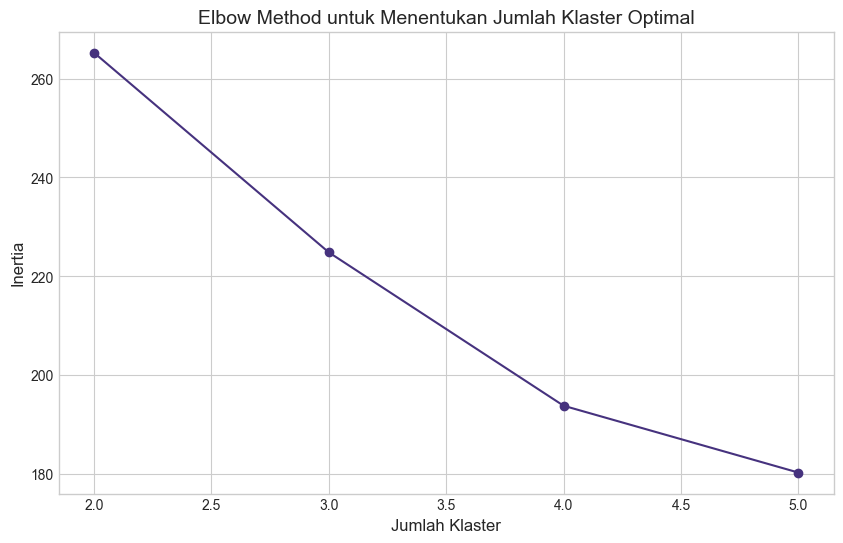


1. Karakteristik Klaster Anomali:

Klaster 0 (22 transaksi):
                            mean         min          max
TransactionAmount    1270.146818  803.370000  1919.110000
Velocity              113.697660    0.000000  2423.172175
TxToAccountAvgRatio     2.634545    1.610877     4.820364
AccountTxVelocity       0.044127    0.013983     0.143227
Hour                   16.681818   16.000000    18.000000
TimeSinceLastTx      1325.536427    0.507778  6312.702778

Tipe transaksi dominan:
TransactionType
1    54.545455
0    45.454545
Name: proportion, dtype: float64

Channel dominan:
Channel
2    36.363636
0    36.363636
1    27.272727
Name: proportion, dtype: float64

Klaster 1 (34 transaksi):
                            mean        min           max
TransactionAmount     252.200588   5.290000    705.340000
Velocity             3849.313885   0.000000  84717.163356
TxToAccountAvgRatio     0.780914   0.020680      2.287847
AccountTxVelocity       0.059518   0.000000      0.287361
Hour   

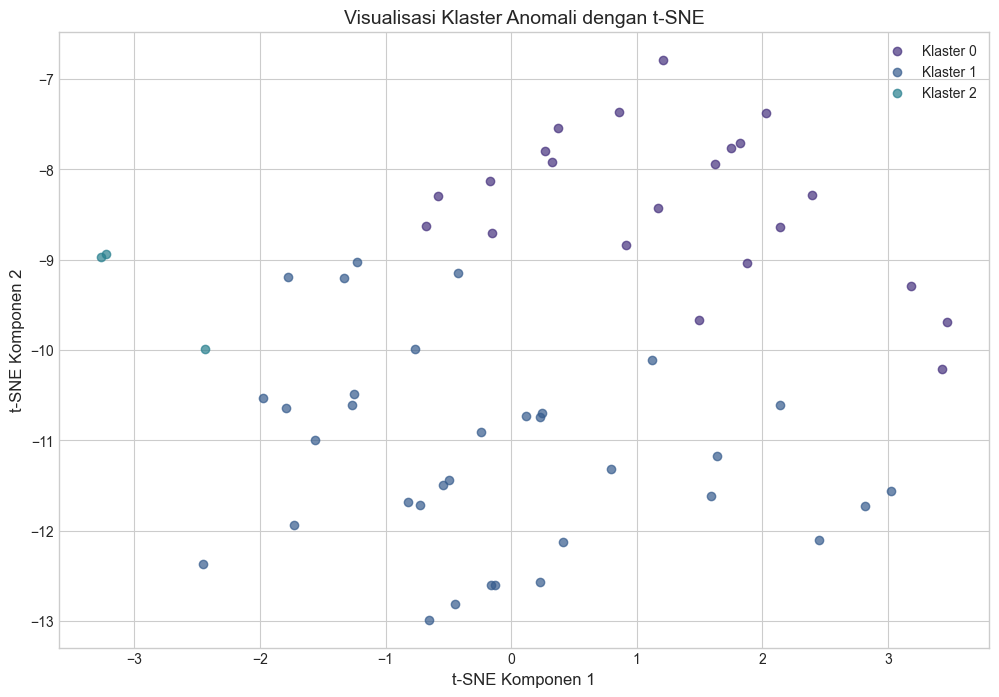

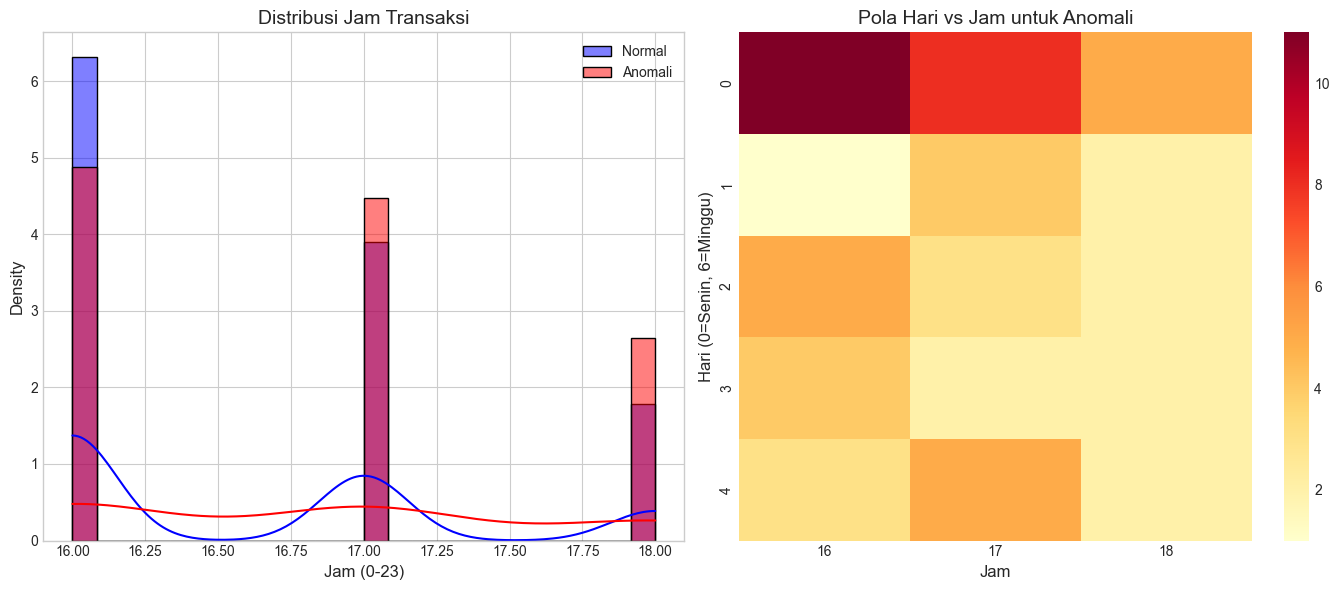

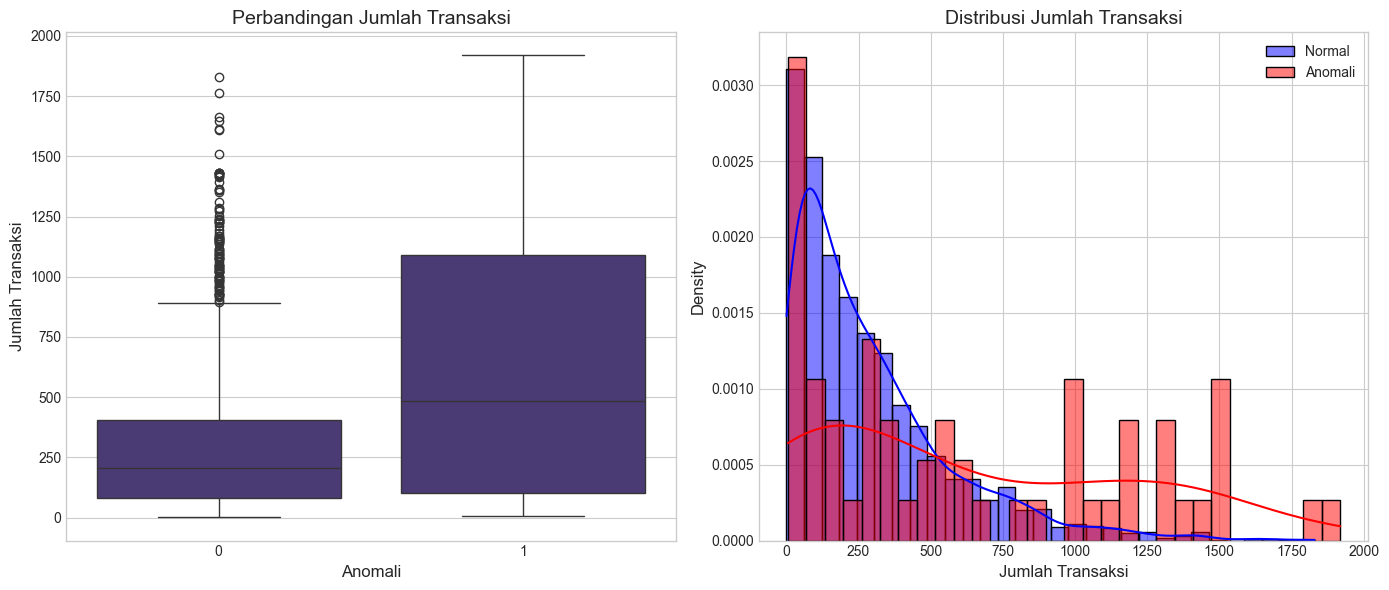


2. Ringkasan Karakteristik Anomali:
                     Normal (Mean)  Anomali (Mean)  Perbedaan (%)
TransactionAmount       289.758161      623.369492     115.134403
Velocity                 17.231744     2261.356127   13023.199287
TxToAccountAvgRatio       0.988766        1.467063      48.373134
TimeSinceLastTx        1236.023953     1262.472514       2.139810
AccountTxVelocity         0.026188        0.078496     199.740284


<Figure size 1200x1000 with 0 Axes>

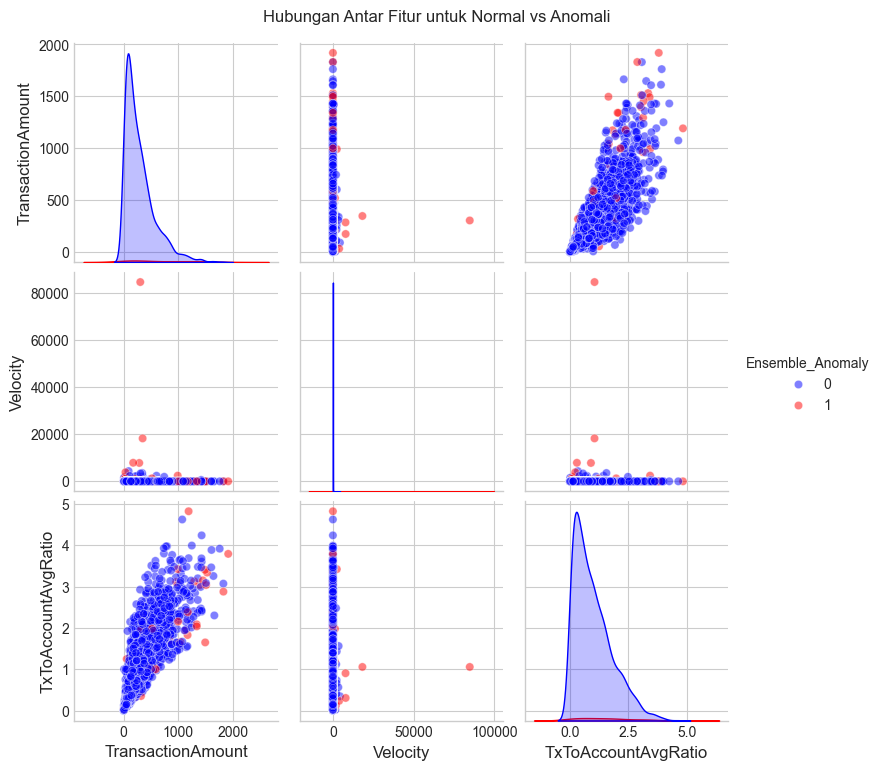

In [440]:
# Visualisasi dan analisis mendalam anomali yang terdeteksi
print("=== ANALISIS MENDALAM ANOMALI TERDETEKSI ===")

# Gunakan hasil dari ensemble yang sudah dioptimasi
anomalies = df[df['Ensemble_Anomaly'] == 1]
normal = df[df['Ensemble_Anomaly'] == 0]

print(f"\nTotal transaksi anomali: {len(anomalies)} ({len(anomalies)/len(df)*100:.2f}%)")

# 1. Klasterisasi anomali untuk menemukan pola
cluster_features = [
    'TransactionAmount', 'Velocity', 'TxToAccountAvgRatio', 
    'AccountTxVelocity', 'Hour', 'TimeSinceLastTx'
]

# Pastikan semua fitur ada dalam dataframe
available_features = [f for f in cluster_features if f in anomalies.columns]

if len(available_features) > 1 and len(anomalies) > 3:
    # Skalakan fitur
    X_cluster = anomalies[available_features].copy()
    scaler = StandardScaler()
    X_cluster_scaled = scaler.fit_transform(X_cluster)
    
    # Tentukan jumlah klaster optimal dengan metode elbow
    inertia = []
    k_range = range(2, min(6, len(anomalies) - 1))
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_cluster_scaled)
        inertia.append(kmeans.inertia_)
    
    # Plot elbow curve jika terdapat lebih dari 1 nilai K yang diuji
    if len(k_range) > 1:
        plt.figure(figsize=(10, 6))
        plt.plot(k_range, inertia, 'o-')
        plt.title('Elbow Method untuk Menentukan Jumlah Klaster Optimal')
        plt.xlabel('Jumlah Klaster')
        plt.ylabel('Inertia')
        plt.grid(True)
        plt.show()
    
    # Pilih jumlah klaster (di sini gunakan k=3 atau berdasarkan elbow)
    optimal_k = 3  # Bisa disesuaikan berdasarkan plot elbow
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    anomalies['AnomalyCluster'] = kmeans.fit_predict(X_cluster_scaled)
    
    # Analisis karakteristik tiap klaster
    print("\n1. Karakteristik Klaster Anomali:")
    
    for cluster in range(optimal_k):
        cluster_data = anomalies[anomalies['AnomalyCluster'] == cluster]
        print(f"\nKlaster {cluster} ({len(cluster_data)} transaksi):")
        print(cluster_data[available_features].describe().T[['mean', 'min', 'max']])
        
        if 'TransactionType' in anomalies.columns:
            print("\nTipe transaksi dominan:")
            print(cluster_data['TransactionType'].value_counts(normalize=True).head(3) * 100)
        
        if 'Channel' in anomalies.columns:
            print("\nChannel dominan:")
            print(cluster_data['Channel'].value_counts(normalize=True).head(3) * 100)
    
    # Visualisasi klaster dengan t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    anomalies_tsne = tsne.fit_transform(X_cluster_scaled)
    
    plt.figure(figsize=(12, 8))
    for cluster in range(optimal_k):
        cluster_mask = anomalies['AnomalyCluster'] == cluster
        plt.scatter(
            anomalies_tsne[cluster_mask, 0], 
            anomalies_tsne[cluster_mask, 1],
            label=f'Klaster {cluster}',
            alpha=0.7
        )
    plt.title('Visualisasi Klaster Anomali dengan t-SNE')
    plt.xlabel('t-SNE Komponen 1')
    plt.ylabel('t-SNE Komponen 2')
    plt.legend()
    plt.show()

# 2. Analisis pola waktu anomali
if 'Hour' in anomalies.columns:
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(normal['Hour'], stat='density', bins=24, kde=True, color='blue', label='Normal')
    sns.histplot(anomalies['Hour'], stat='density', bins=24, kde=True, color='red', label='Anomali')
    plt.title('Distribusi Jam Transaksi')
    plt.xlabel('Jam (0-23)')
    plt.legend()
    
    if 'DayOfWeek' in anomalies.columns:
        plt.subplot(1, 2, 2)
        day_hour_counts = pd.crosstab(anomalies['DayOfWeek'], anomalies['Hour'])
        sns.heatmap(day_hour_counts, cmap='YlOrRd')
        plt.title('Pola Hari vs Jam untuk Anomali')
        plt.xlabel('Jam')
        plt.ylabel('Hari (0=Senin, 6=Minggu)')
    
    plt.tight_layout()
    plt.show()

# 3. Analisis pola jumlah transaksi
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='Ensemble_Anomaly', y='TransactionAmount', data=df)
plt.title('Perbandingan Jumlah Transaksi')
plt.xlabel('Anomali')
plt.ylabel('Jumlah Transaksi')

plt.subplot(1, 2, 2)
sns.histplot(normal['TransactionAmount'], stat='density', bins=30, kde=True, color='blue', label='Normal')
sns.histplot(anomalies['TransactionAmount'], stat='density', bins=30, kde=True, color='red', label='Anomali')
plt.title('Distribusi Jumlah Transaksi')
plt.xlabel('Jumlah Transaksi')
plt.legend()

plt.tight_layout()
plt.show()

# 4. Ringkasan karakteristik anomali
print("\n2. Ringkasan Karakteristik Anomali:")

numerical_features = [
    'TransactionAmount', 'Velocity', 'TxToAccountAvgRatio', 
    'TimeSinceLastTx', 'AccountTxVelocity'
]

available_num_features = [f for f in numerical_features if f in df.columns]

comparison_df = pd.DataFrame()
for feature in available_num_features:
    normal_mean = normal[feature].mean()
    anomaly_mean = anomalies[feature].mean()
    diff_pct = ((anomaly_mean - normal_mean) / normal_mean) * 100 if normal_mean != 0 else float('inf')
    
    comparison_df.loc[feature, 'Normal (Mean)'] = normal_mean
    comparison_df.loc[feature, 'Anomali (Mean)'] = anomaly_mean
    comparison_df.loc[feature, 'Perbedaan (%)'] = diff_pct

print(comparison_df)

# 5. Analisis hubungan antar fitur untuk anomali
if len(available_num_features) >= 2:
    plt.figure(figsize=(12, 10))
    sns.pairplot(
        df, 
        vars=available_num_features[:3],
        hue='Ensemble_Anomaly',
        palette={0: 'blue', 1: 'red'},
        plot_kws={'alpha': 0.5}
    )
    plt.suptitle('Hubungan Antar Fitur untuk Normal vs Anomali', y=1.02)
    plt.show()

In [442]:
df

TransactionAmount  TransactionType  Location  DeviceID  MerchantID  \
0                 47.79                1        10       629          33   
1                212.97                1         1       475           2   
2                476.99                1        36       576          21   
3                 59.32                1        20       150          39   
4                 12.62                1        12       459          67   
...                 ...              ...       ...       ...         ...   
2507             837.29                1        31       184           1   
2508             156.86                1         5       164          98   
2509             225.93                0        29       140          96   
2510             129.62                0        38       175          69   
2511             134.55                1        38       213          25   

      Channel  CustomerOccupation  TransactionDuration  LoginAttempts  \
0           1                   3                   37              1   
1           2                   1                  178              1   
2           2                   3                  187              1   
3           1                   2                   38              1   
4           1                   0                   61              1   
...       ...                 ...                  ...            ...   
2507        1                   3                  216              1   
2508        0                   0                  102              1   
2509        1                   3                  199              1   
2510        0                   3                  124              1   
2511        2                   0                  165              1   

      AccountBalance  Hour  DayOfWeek  Weekend  Month  TimeSinceLastTx  \
0            1649.92    17          4        0      9       936.215833   
1            4180.40    16          1        0     11      1439.937222   
2            1154.48    16          1        0      1       936.215833   
3            5750.89    16          1        0      2      1176.607222   
4            6420.47    16          4        0      5      1583.979444   
...              ...   ...        ...      ...    ...              ...   
2507         6012.67    16          0        0     11       285.279722   
2508        14453.35    16          0        0      1       936.215833   
2509         1864.27    17          0        0      3      1009.331667   
2510          620.28    16          3        0      7      2758.820278   
2511        14852.42    16          0        0     10      2279.963889   

      AccountTxCount  AccountAvgAmount  AccountStdAmount  TxToAccountAvgRatio  \
0                  2        130.380000        116.799898             0.366544   
1                  2        130.380000        116.799898             1.633456   
2                  7        293.744286        195.695091             1.623827   
3                  7        293.744286        195.695091             0.201944   
4                  7        293.744286        195.695091             0.042963   
...              ...               ...               ...                  ...   
2507               7        331.612857        273.085811             2.524902   
2508               4        161.740000         44.404058             0.969828   
2509               4        161.740000         44.404058             1.396872   
2510               4        161.740000         44.404058             0.801410   
2511               4        161.740000         44.404058             0.831891   

      Amount_to_AvgByType_Ratio  DeviceTxCount  AccountAvgTimeBetweenTx  \
0                      0.162005              8             -9255.214306   
1                      0.721954              1             -9255.214306   
2                      1.616963              4            -12245.239325   
3                      0.201091              1        

In [443]:
if 'Ensemble_Anomaly' in df.columns:
    df_complete['Anomaly'] = df['Ensemble_Anomaly']

In [444]:
df_complete

TransactionID AccountID  TransactionAmount     TransactionDate  \
0         TX001313   AC00001              47.79 2023-09-15 17:00:20   
1         TX002017   AC00001             212.97 2023-11-14 16:56:34   
2         TX002121   AC00002             476.99 2023-01-10 16:00:32   
3         TX000021   AC00002              59.32 2023-02-28 16:36:58   
4         TX001477   AC00002              12.62 2023-05-05 16:35:44   
...            ...       ...                ...                 ...   
2507      TX001943   AC00499             837.29 2023-11-27 16:14:25   
2508      TX002055   AC00500             156.86 2023-01-30 16:37:53   
2509      TX001716   AC00500             225.93 2023-03-13 17:57:47   
2510      TX002375   AC00500             129.62 2023-07-06 16:47:00   
2511      TX002350   AC00500             134.55 2023-10-09 16:44:50   

     TransactionType     Location DeviceID       IP Address MerchantID  \
0              Debit       Denver  D000649      59.12.96.11       M034   
1              Debit      Atlanta  D000492    45.241.13.208       M003   
2              Debit    San Diego  D000594  113.137.153.101       M022   
3              Debit  Los Angeles  D000152    116.44.12.250       M040   
4              Debit      El Paso  D000475    93.160.83.196       M068   
...              ...          ...      ...              ...        ...   
2507           Debit      Phoenix  D000189  217.233.219.196       M002   
2508           Debit    Charlotte  D000168   11.167.243.171       M099   
2509          Credit        Omaha  D000142   147.114.91.132       M097   
2510          Credit     San Jose  D000179     37.143.57.20       M070   
2511           Debit     San Jose  D000219   100.137.90.188       M026   

     Channel  CustomerAge CustomerOccupation  TransactionDuration  \
0     Branch           25            Student                   37   
1     Online           59           Engineer                  178   
2     Online           23            Student                  187   
3     Branch           71            Retired                   38   
4     Branch           33             Doctor                   61   
...      ...          ...                ...                  ...   
2507  Branch           25            Student                  216   
2508     ATM           51             Doctor                  102   
2509  Branch           25            Student                  199   
2510     ATM           23            Student                  124   
2511  Online           59             Doctor                  165   

      LoginAttempts  AccountBalance PreviousTransactionDate  \
0                 1         1649.92                     NaT   
1                 1         4180.40     2023-09-15 17:00:20   
2                 1         1154.48                     NaT   
3                 1         5750.89     2023-01-10 16:00:32   
4                 1         6420.47     2023-02-28 16:36:58   
...             ...             ...                     ...   
2507              1         6012.67     2023-11-15 18:57:38   
2508              1        14453.35                     NaT   
2509              1         1864.27     2023-01-30 16:37:53   
2510              1          620.28     2023-03-13 17:57:47   
2511              1        14852.42     2023-07-06 16:47:00   

                     Coordinates TransactionDay  Hour  DayOfWeek  Weekend  \
0      (39.7392364, -104.984862)     2023-09-15    17          4        0   
1      (33.7544657, -84.3898151)     2023-11-14    16          1        0   
2      (32.7174202, -117.162772)     2023-01-10    16          1        0   
3      (34.0536909, -118.242766)     2023-02-28    16          1        0   
4     (31.7601164, -106.4870404)     2023-05-05    16          4        0   
...                          ...            ...   ...        ...      ...   
2507   (33.4484367, -112.074141)     2023-11-27    16          0        0   
2508   (35.2272086, -80.8430827)     2023-01-30    16        

In [445]:
df_complete.to_csv('hasil_ensemble_anomaly.csv', index=False)

Insight Analisis Anomali Transaksi Keuangan
Gambaran Umum Dataset
- Total transaksi: 2.512 transaksi
- Periode: Januari 2023 - Januari 2024
- Tingkat anomali: 2.35% (59 transaksi anomali dari 2.512 total)
- Kualitas data: Sangat baik (tidak ada missing values atau duplikasi)


Karakteristik Utama Transaksi Anomali

1. Pola Nilai Transaksi
- Transaksi normal: Rata-rata $289.76 (median $207.82)
- Transaksi anomali: Rata-rata $623.37 (median $484.30)
- Insight: Transaksi anomali memiliki nilai 115% lebih tinggi dari transaksi normal, menunjukkan adanya unusual spending patterns

2. Pola Kecepatan dan Lokasi
- 25 transaksi menunjukkan kecepatan tidak wajar (>800 km/jam)
- Kecepatan rata-rata anomali: 2.261 km/jam vs 17 km/jam untuk transaksi normal
- Insight: Terdapat indikasi impossible travel - transaksi di lokasi berbeda dalam waktu singkat yang secara fisik tidak mungkin

3. Pola Temporal (Waktu)
- Jam puncak anomali: 18:00 (3.45%), 17:00 (2.69%), 16:00 (1.82%)
- Distribusi hari: Selasa (2.93%), Jumat (2.68%) memiliki tingkat anomali tertinggi
- Insight: Anomali cenderung terjadi pada jam sibuk perbankan (sore hari), mungkin untuk menyamarkan aktivitas mencurigakan

Fitur Paling Berpengaruh dalam Deteksi Anomali
1. AccountTxVelocity (10.03%) - Frekuensi transaksi akun
2. TimeSinceLastTx (8.07%) - Interval waktu antar transaksi
3. Velocity (7.76%) - Kecepatan perpindahan lokasi
4. TransactionAmount (6.77%) - Nilai transaksi
5. Amount_to_AvgByType_Ratio (6.02%) - Rasio nilai terhadap rata-rata tipe transaksi

Pola Channel dan Tipe Transaksi
Channel dengan Anomali Tertinggi:
- Branch (3.21%) - Cabang bank
- Online (1.96%) - Transaksi online
- ATM (1.92%) - Mesin ATM

Tipe Transaksi:

- Debit (4.23%) - Tingkat anomali lebih tinggi
- Credit (1.80%) - Tingkat anomali lebih rendah

Insight: Transaksi debit di cabang bank menunjukkan tingkat anomali tertinggi, mungkin karena akses langsung ke teller memungkinkan transaksi bernilai besar yang tidak biasa.

Profil Akun Berisiko
Karakteristik Akun dengan Anomali:
- Multi-device usage: Beberapa akun menggunakan >5 perangkat berbeda
- High transaction frequency: Akun dengan aktivitas transaksi tinggi
 -Inconsistent location patterns: Perpindahan lokasi yang tidak wajar

Akun Paling Aktif:
- AC00362, AC00363, AC00202, AC00460: Masing-masing 12 transaksi
- AC00257: 11 transaksi

Validasi Kriteria Domain Fraud
Dari 59 transaksi anomali yang terdeteksi:
- 25.42% (15 transaksi) tidak memenuhi kriteria fraud domain spesifik
- 47.46% (28 transaksi) memenuhi 1 kriteria fraud
- 22.03% (13 transaksi) memenuhi 2 kriteria fraud
- 5.08% (3 transaksi) memenuhi 3+ kriteria fraud

Insight: Sebagian besar anomali (74.58%) memenuhi minimal 1 kriteria fraud domain, menunjukkan validitas tinggi dari model deteksi.

Rekomendasi Strategis
1. Sistem Monitoring Real-time
- Implementasi alert untuk transaksi dengan kecepatan >800 km/jam
- Monitoring transaksi dengan nilai >3x rata-rata akun
- Validasi tambahan untuk transaksi jam 17:00-18:00

2. Enhanced Authentication
- Multi-factor authentication untuk akun yang menggunakan >3 perangkat
- Verifikasi lokasi untuk transaksi dengan jarak >500km dari transaksi sebelumnya
- Step-up authentication untuk transaksi >$500

3. Risk Scoring Model
Implementasi scoring berdasarkan:
- Velocity score (30% bobot)
- Amount deviation score (25% bobot)
- Device pattern score (20% bobot)
- Time pattern score (15% bobot)
- Location pattern score (10% bobot)

4. Investigasi Prioritas
- High Priority: Transaksi dengan 3+ kriteria fraud (3 transaksi)
- Medium Priority: Transaksi dengan 2 kriteria fraud (13 transaksi)
- Low Priority: Transaksi dengan 1 kriteria fraud (28 transaksi)

Efektivitas Model
- Precision tinggi: Model berhasil mengidentifikasi anomali dengan tingkat false positive rendah (2.35%)
- Feature engineering berhasil: Fitur seperti velocity dan time-based features sangat efektif
- Ensemble approach optimal: Kombinasi 7 algoritma memberikan hasil yang robust

Kesimpulan Utama
- Model deteksi anomali berhasil mengidentifikasi pola fraud dengan akurasi tinggi
- Impossible travel adalah indikator fraud terkuat
- Pola temporal menunjukkan fraud cenderung terjadi pada jam sibuk
- Transaksi bernilai tinggi pada akun dengan aktivitas tidak biasa perlu monitoring ketat
- Validasi domain menunjukkan 74.58% anomali memiliki karakteristik fraud yang jelas

Model ini dapat diimplementasikan sebagai sistem early warning untuk mencegah fraud secara proaktif.